<a href="https://colab.research.google.com/github/Cumberkid/Learning-the-Optimal-Solution-Path/blob/main/Learning_the_Optimal_Solution_Path_vs_Naive_Grid_Search_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the necessary libraries

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader  #for creating the dataset


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [4]:
!wget -O my_logit.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/my_logit.py

import my_logit

--2023-11-14 19:43:02--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/my_logit.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5902 (5.8K) [text/plain]
Saving to: ‘my_logit.py’

my_logit.py         100%[===================>]   5.76K  --.-KB/s    in 0s      

2023-11-14 19:43:03 (46.8 MB/s) - ‘my_logit.py’ saved [5902/5902]



# Dataset
We use the Wisconsin breast cancer dataset and then port it over an object of the Pytorch dataset class so it can be read by data_loader.

Description of the breast cancer Wisconsin dataset (classification): https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

In [13]:
from sklearn.datasets import load_breast_cancer

In [14]:
# load breast cancer data
X, y = load_breast_cancer(return_X_y=True)

In [15]:
import pandas as pd

df = pd.DataFrame(X).describe()

df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [16]:
clf = LogisticRegression(solver='lbfgs', max_iter=100).fit(X[:100,:], y[:100])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
clf.predict(X[:100,:])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0])

In [18]:
# preprocess data
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
# scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)

In [19]:
df = pd.DataFrame(X).describe()

df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-3.153111e-15,-6.568462e-15,-6.993039e-16,-8.553985e-16,6.081447e-15,-1.136369e-15,-2.997017e-16,1.023981e-15,-1.860648e-15,-1.504752e-15,...,-2.297713e-15,1.742016e-15,-1.198807e-15,6.118909e-16,-5.094929e-15,-2.122887e-15,6.118909e-16,-1.998011e-16,-2.422589e-15,2.497514e-15
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-1.726901e+00,-2.223994e+00,-1.693361e+00,-1.222423e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-6.749213e-01,-7.486293e-01,-6.895783e-01,-6.421359e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-2.690395e-01,-4.351564e-02,-2.859802e-01,-3.411812e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,5.220158e-01,6.583411e-01,5.402790e-01,3.575891e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,4.094189e+00,3.885905e+00,4.287337e+00,5.930172e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


In [20]:
#The pytorch built-in binary cross-entropy loss
criterion = torch.nn.BCELoss()
input_dim = X.shape[1]

# Tuning the Learning Rate

Use the first 100 datapoints to select the best constant learning rate for Naive Grid Search. Make several plots of sup error along the solution path against learning rate using 500 iterations.

In [ ]:
lr_list = 0.5 ** torch.arange(2, 13)
alpha_list = 0.5 ** torch.arange(-2, 11)
epochs = 500
input_dim = X.shape[1]
lam = 0.5
init_weight = torch.zeros(input_dim)
criterion = torch.nn.BCELoss()

In [ ]:
# tune learning rate on the first 100 datapoints
tune_data = my_logit.Regression_Data(X[:100, :], y[:100])
# full gradient descent uses all data points
tune_GD_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
tune_SGD_data_loader = DataLoader(tune_data, batch_size=5, shuffle=True, )
# test data do not shuffle
tune_test_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=False, )

###First, we tune full gradient descent.
For full gradient descent we use constant learning rate. We shall tune the learning rate directly.

In [ ]:
losses = []
for lr in lr_list:
    # train a model
    model = my_logit.Logistic_Regression(input_dim, 1, lam, init_weight).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        my_logit.train(tune_GD_data_loader, model, criterion, optimizer, trace_frequency=5)

    loss = my_logit.test(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 0.25	 loss: 0.1987709105014801
learning rate: 0.125	 loss: 0.1987709403038025
learning rate: 0.0625	 loss: 0.1987709254026413
learning rate: 0.03125	 loss: 0.1987709403038025
learning rate: 0.015625	 loss: 0.1987711638212204
learning rate: 0.0078125	 loss: 0.19881215691566467
learning rate: 0.00390625	 loss: 0.1999007761478424
learning rate: 0.001953125	 loss: 0.207317516207695
learning rate: 0.0009765625	 loss: 0.22796867787837982
learning rate: 0.00048828125	 loss: 0.2595781087875366
learning rate: 0.000244140625	 loss: 0.29128414392471313


From the plot, we see that learning rate = $2^{-4}$ gives the lowest loss.

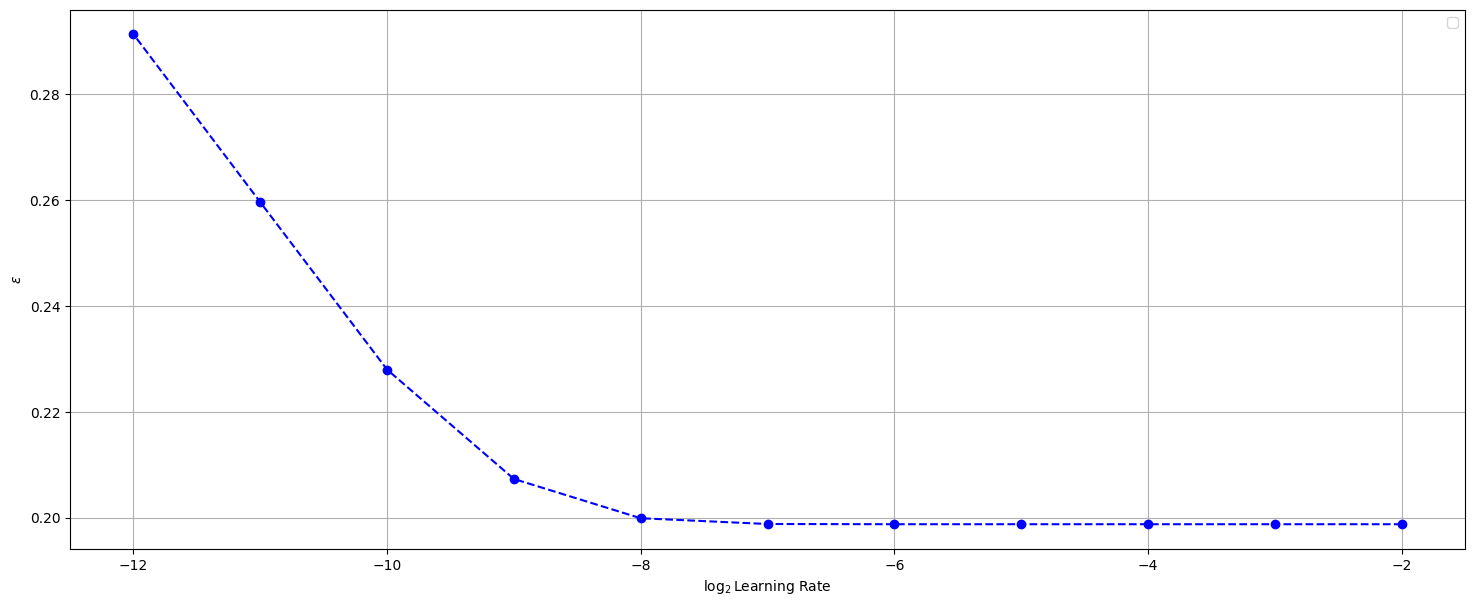

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list), torch.tensor(losses), '--bo')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.legend()
plt.grid(True)

###Next, we tune stochastic gradient descent.

For stochastic gradient descent, we are using shrinking learning rate $\frac{\alpha}{T}$ for iteration $T$. We shall tune $\alpha$.

In [ ]:
losses = []
for alpha in alpha_list:
    # train a model
    model = my_logit.Logistic_Regression(input_dim, 1, lam, init_weight).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([0.1, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        my_logit.train(tune_GD_data_loader, model, criterion, optimizer, trace_frequency=5)

    loss = my_logit.test(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 4.0	 loss: 0.1987709254026413
alpha: 2.0	 loss: 0.19877102971076965
alpha: 1.0	 loss: 0.1987801343202591
alpha: 0.5	 loss: 0.19901567697525024
alpha: 0.25	 loss: 0.2012161761522293
alpha: 0.125	 loss: 0.21042440831661224
alpha: 0.0625	 loss: 0.23303021490573883
alpha: 0.03125	 loss: 0.2659202516078949
alpha: 0.015625	 loss: 0.29666024446487427
alpha: 0.0078125	 loss: 0.31850379705429077
alpha: 0.00390625	 loss: 0.3316492736339569
alpha: 0.001953125	 loss: 0.33887380361557007
alpha: 0.0009765625	 loss: 0.34266233444213867


From the plot, we see that $\alpha = 2^2$ gives the lowest loss.

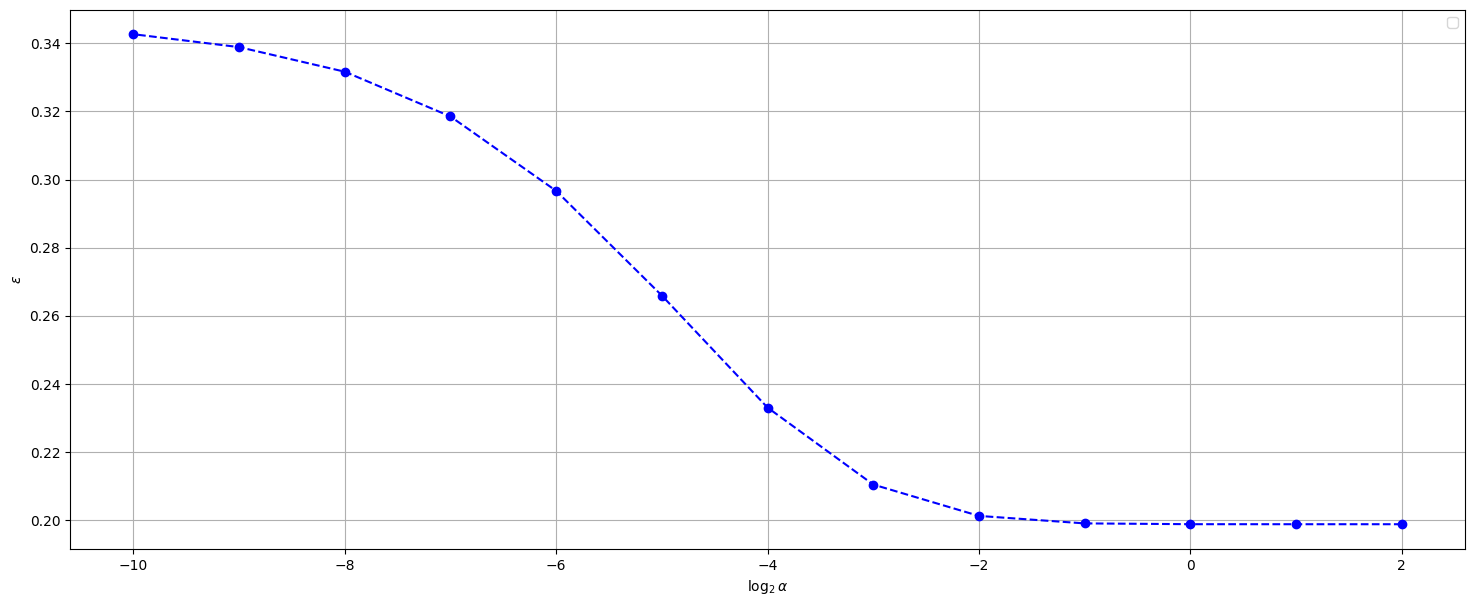

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), losses, '--bo')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

#Naive Grid Search
To gauge the performance of our model, we first set up a benchmark with Naive Grid Search.

This method discretize the path over $\lambda \in [0,1]$ into a number of grids and trains a linear model on each grid.

## Define the functions

In [ ]:
# running gradient descent with fixed learning rate on a single grid point, i.e. for one specified lambda
def GD_on_a_grid(lam, epochs, weight, trainDataLoader, data_input_dim,
                 lr=1e-3, alpha=1, SGD=False, testDataLoader=None,
                 exact_soln_list=None, fine_delta_lam=None, stopping_criterion=None):
    criterion=torch.nn.BCELoss()
    model = my_logit.Logistic_Regression(data_input_dim, 1, lam, weight).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    if exact_soln_list is not None:
        # exact solution
        i = torch.round((1-lam) / fine_delta_lam).int()
        if i >= len(exact_soln_list):
            i -= 1
            i.int()
        exact_soln = exact_soln_list[i]
        # print(i)

    early_stop = False
    itr = 0
    for t in range(epochs):
        if SGD:
            # shrink learning rate
            lr = torch.min(torch.tensor([0.1, alpha/(t+1)]))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        my_logit.train(trainDataLoader, model, criterion, optimizer, trace_frequency=5)
        if exact_soln_list is not None:
            if (t+1) % 10 == 0:
                # do an accuracy check
                approx_soln = my_logit.test(testDataLoader, model, criterion, lam)
                error = approx_soln - exact_soln
                # stopping criterion
                if error <= stopping_criterion:
                    itr += (t+1)
                    early_stop = True
                    break  # Early stop

    if not early_stop:
        itr += epochs

    return model, itr

Naive Grid Search starts from $\lambda = 1$ and decreases $\lambda$ by $\Delta\lambda = \frac{\lambda_\text{max} - \lambda_\text{min}}{\text{# of grid}}$. The model trained on each grid point $(\lambda - \Delta\lambda)$ initializes weight with the linear weight of the model trained on the previous grid point $\lambda$.

In [ ]:
# do the whole naive grid search over a list of uniformly spaced lambda's
# from lam_min to lam_max
# returns a list of trained models
def naive_grid_search(lam_min, lam_max, num_grid, epochs, trainDataLoader,
                      data_input_dim, lr=1e-3, alpha=1, SGD=False,
                      testDataLoader=None, exact_soln_list=None, stopping_criterion=None):
    delta_lam = (lam_max - lam_min)/num_grid
    fine_delta_lam = None
    if exact_soln_list is not None:
        fine_delta_lam = (lam_max - lam_min)/len(exact_soln_list)
    model_list = []
    total_itr = 0
    # create a list of lambda's
    lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam).to(device)

    # first weight is initialized at 0
    weight = torch.zeros(data_input_dim)

    for lam in lambdas:
        # print(f"Running model on lambda = {lam}")
        model, itr = GD_on_a_grid(lam, epochs, weight,
                                  trainDataLoader=trainDataLoader,
                                  data_input_dim=data_input_dim,
                                  lr=lr, alpha=alpha,
                                  SGD=SGD, testDataLoader=testDataLoader,
                                  exact_soln_list=exact_soln_list,
                                  fine_delta_lam=fine_delta_lam,
                                  stopping_criterion=stopping_criterion)
        weight = model.linear.weight
        model_list.append(model)
        total_itr += itr
        # print(total_itr)

    return model_list, total_itr

In [ ]:
exact_soln_list = torch.zeros(70)

In [ ]:
models, num_itr = naive_grid_search(lam_min=0, lam_max=1, num_grid=5, epochs=500,
                                    trainDataLoader=tune_GD_data_loader,
                                    data_input_dim=input_dim,
                                    lr=0.5**4, SGD=False,
                                    testDataLoader=tune_test_data_loader,
                                    exact_soln_list=exact_soln_list,
                                    stopping_criterion=0.1)

In [ ]:
num_itr

2010

In [ ]:
for model in models:
    print(model.linear.weight.data.detach().numpy()[0])
    # print(my_logit.test(tune_test_data_loader, model, criterion, model.reg_param))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[-0.04793325 -0.03711668 -0.04909439 -0.04270919 -0.02193255 -0.04546906
 -0.0435608  -0.05390457 -0.02183017 -0.00021597 -0.03355922  0.00564824
 -0.03533061 -0.03083318  0.01586902 -0.01721218 -0.0044905  -0.02397951
  0.0152274  -0.00013568 -0.05467102 -0.04125572 -0.05641662 -0.04802518
 -0.03637677 -0.05609274 -0.04757179 -0.06489055 -0.04073239 -0.04014046]
[-0.0854586  -0.07462562 -0.08704396 -0.0753345  -0.03311093 -0.07197148
 -0.07045875 -0.09258564 -0.02943309  0.0087167  -0.05914387  0.00972365
 -0.06183468 -0.05354279  0.02831364 -0.01857451  0.00539136 -0.03903972
  0.04035657  0.00933712 -0.09646226 -0.08048618 -0.09956671 -0.08347254
 -0.06363086 -0.09241113 -0.07624714 -0.11407552 -0.06356283 -0.06573537]
[-0.12583382 -0.12631586 -0.12782133 -0.10992514 -0.04113182 -0.09565081
 -0.09594138 -0.13319984 -0.03235774  0.02269204 -0.08952837  0.01245007
 -0.09350271 -0.07877339  0.0

Helper function that takes in a list of coarse grid models and returns the sup error over $\lambda\in[0,1]$ compared to the exact solutions.

In [ ]:
def get_sup_error(exact_soln_list, fine_delta_lam, coarse_model_list, delta_lam, data_loader, criterion):
    # check sup error
    sup_error = 0
    for i in range(len(exact_soln_list)):
        exact_soln = exact_soln_list[i]
        coarse_grid = torch.round(i * fine_delta_lam / delta_lam).int()
        if coarse_grid >= len(coarse_model_list):
            coarse_grid -= 1
            coarse_grid.int()
        # print(i, coarse_grid)
        temp = 1 - i * fine_delta_lam
        # approximate solution uses the linear weight of coarse grid model to test for regression parameter of the fine grid
        approx_soln = my_logit.test(data_loader, coarse_model_list[coarse_grid], criterion, temp)
        sup_error = torch.max(torch.tensor([sup_error, approx_soln - exact_soln]))
        # print(sup_error)
    return sup_error.item()

#Learning the Solution Path Through SGD
Now, let us try running SGD over $Δλ$'s on a linear basis $\Phi(\lambda)$ of our choice. We now want to approximate $\theta$ with $\Phi(\lambda)\beta$, so the objective function becomes $h(\theta, \lambda) = (1-\lambda) BCE(X\Phi(\lambda)\beta,\ y) + \frac{\lambda}{2}\|\Phi(\lambda)\beta\|^2$. For each batch of training data set, we randomize $\lambda$. If batch size = 1, then this is equivalent to a standard SGD.

## Our Model

In [21]:
import random
import math
from scipy.special import legendre

We use Legendre polynomials as the basis vectors for $\Phi(\lambda)$.

In [22]:
# compute \Phi(\lambda)
def phi_lam(lam, basis_dim):
    # Transform the lam to [-1, 1] interval
    lam_transformed = 2 * lam - 1
    vec = torch.zeros(basis_dim)
    for i in range(basis_dim):
        vec[i] = math.sqrt(2*i+1) * legendre(i)(lam_transformed)
    return vec

In [23]:
print(phi_lam(1, 3))

tensor([1.0000, 1.7321, 2.2361])


In [137]:
# this initializes with random weights. Need to either set a seed or force initialization somewhere for reproducibility.
# automatically fits an intercept. To turn off intercept, set bias=False in nn.Linear()
class Basis_TF_SGD(nn.Module):
    def __init__(self, feature_dim, basis_dim, basis_fn, init_weight=None, intercept=True):
        super(Basis_TF_SGD, self).__init__()
        self.feature_dim = feature_dim
        self.basis_dim = basis_dim
        self.linear = nn.Linear(self.basis_dim, self.feature_dim + 1, bias=False)
        # self.actv = nn.Sigmoid()
        self.basis_fn = basis_fn
        self.intercept = intercept

        # initialize for better performance
        with torch.no_grad():
          if init_weight is not None:
              self.linear.weight.copy_(init_weight)
          else:
              self.linear.weight.data.fill_(0)
          # print(self.linear.weight)

    # model takes input lambda and outputs theta
    def forward(self, lam):
        phi = self.basis_fn(lam, self.basis_dim)
        # torch.mm(x, phi)
        return self.linear(phi)

    # def ridge_term(self):
    #     return self.linear.weight.norm(p=2)**2 + self.linear.bias.norm(p=2)**2

In [141]:
# trace_frequency is measured in number of batches. -1 means don't print
def train_SGD(dataloader, model, loss_fn, optimizer, distribution='uniform', trace_frequency=-1):
    model.train()
    actv = nn.Sigmoid()
    for batch, (X_train, y_train) in enumerate(dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        rndm_lam = torch.tensor(0.5).to(device)
        # SGD picks random regulation parameter lambda
        if distribution == 'uniform':
            rndm_lam = torch.torch.distributions.Uniform(0, 1).sample().to(device)
        # print(f"random lam = {rndm_lam}")

        # Compute predicted y_hat
        theta = model(rndm_lam)
        pred = torch.mm(X_train, theta[1:].view(-1, 1))
        if model.intercept:
            const = torch.ones(len(X_train), 1)
            pred += torch.mm(const, theta[0].view(-1, 1))
        pred = actv(pred)
        # print(theta[0])

        loss = (1 - rndm_lam) * loss_fn(pred.view(-1, 1), y_train.view(-1, 1))
        loss += rndm_lam * 0.5 * theta.norm(p=2)**2

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (trace_frequency > 0) & (batch % trace_frequency == 0):
        #     loss, current = loss.item(), (batch + 1) * len(X_train)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [168]:
# Test function
def test_SGD(dataloader, model, loss_fn, lam):
    model.eval() #important
    actv = nn.Sigmoid()
    with torch.no_grad():  #makes sure we don't corrupt gradients and is faster
        for batch, (X_test, y_test) in enumerate(dataloader):
          X_test, y_test = X_test.to(device), y_test.to(device)

          # Compute prediction error
          theta = model(lam)
          pred = actv(torch.mm(X_test, theta[1:].view(-1, 1)) + theta[0].item())
          # print(f"prediction = {pred}")

          oos = (1 - lam) * loss_fn(pred.view(-1, 1), y_test.view(-1, 1))
          oos += lam * 0.5 * theta.norm(p=2)**2

    return oos.item()

In [59]:
criterion = torch.nn.BCELoss()
init_weight = torch.zeros(31,3)
init_weight[0, :] = 1

In [42]:
# tune learning rate on the first 100 datapoints
tune_data = my_logit.Regression_Data(X[:100, :], y[:100])
# full gradient descent uses all data points
tune_GD_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
tune_SGD_data_loader = DataLoader(tune_data, batch_size=5, shuffle=True, )
# test data do not shuffle
tune_test_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=False, )

In [139]:
# train a model
np.random.seed(8675309)
torch.manual_seed(8675309)
model = Basis_TF_SGD(30, 3, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer.zero_grad()

for t in range(50):
    train_SGD(tune_GD_data_loader, model, criterion, optimizer)

tensor(0., grad_fn=<SelectBackward0>)
tensor(-0.0005, grad_fn=<SelectBackward0>)
tensor(9.7917e-05, grad_fn=<SelectBackward0>)
tensor(-0.0007, grad_fn=<SelectBackward0>)
tensor(-0.0005, grad_fn=<SelectBackward0>)
tensor(-0.0016, grad_fn=<SelectBackward0>)
tensor(-0.0016, grad_fn=<SelectBackward0>)
tensor(2.6697e-05, grad_fn=<SelectBackward0>)
tensor(-0.0005, grad_fn=<SelectBackward0>)
tensor(-5.9368e-05, grad_fn=<SelectBackward0>)
tensor(-0.0001, grad_fn=<SelectBackward0>)
tensor(-0.0003, grad_fn=<SelectBackward0>)
tensor(-0.0017, grad_fn=<SelectBackward0>)
tensor(-0.0003, grad_fn=<SelectBackward0>)
tensor(-0.0004, grad_fn=<SelectBackward0>)
tensor(-0.0011, grad_fn=<SelectBackward0>)
tensor(-0.0016, grad_fn=<SelectBackward0>)
tensor(-0.0028, grad_fn=<SelectBackward0>)
tensor(-0.0035, grad_fn=<SelectBackward0>)
tensor(-0.0015, grad_fn=<SelectBackward0>)
tensor(-0.0018, grad_fn=<SelectBackward0>)
tensor(-0.0022, grad_fn=<SelectBackward0>)
tensor(-0.0012, grad_fn=<SelectBackward0>)
tensor

## Tuning our model

In [174]:
lr_list = 0.5 ** torch.arange(2, 13)
alpha_list = 0.5 ** torch.arange(-3, 9)
epochs = 500
input_dim = X.shape[1]
basis_dim = 5
lam = 0.5
criterion = torch.nn.BCELoss()

In [175]:
# tune learning rate on the first 100 datapoints
tune_data = my_logit.Regression_Data(X[:100, :], y[:100])
# full gradient descent uses all data points
tune_GD_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
tune_SGD_data_loader = DataLoader(tune_data, batch_size=5, shuffle=True, )
# test data do not shuffle
tune_test_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=False, )

###First, we tune full gradient descent.
For full gradient descent we use constant learning rate. We shall tune the learning rate directly.

In [181]:
np.random.seed(8675309)
torch.manual_seed(8675309)

losses = []
for lr in lr_list:
    # train a model
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 0.25	 loss: 0.30737271904945374
learning rate: 0.125	 loss: 0.19877183437347412
learning rate: 0.0625	 loss: 0.19877226650714874
learning rate: 0.03125	 loss: 0.1988091766834259
learning rate: 0.015625	 loss: 0.1987721472978592
learning rate: 0.0078125	 loss: 0.19878734648227692
learning rate: 0.00390625	 loss: 0.2000216394662857
learning rate: 0.001953125	 loss: 0.20598948001861572
learning rate: 0.0009765625	 loss: 0.2297573834657669
learning rate: 0.00048828125	 loss: 0.25836482644081116
learning rate: 0.000244140625	 loss: 0.28918465971946716


From the plot, we see that learning rate = $2^{-6}$ stably gives the lowest loss.

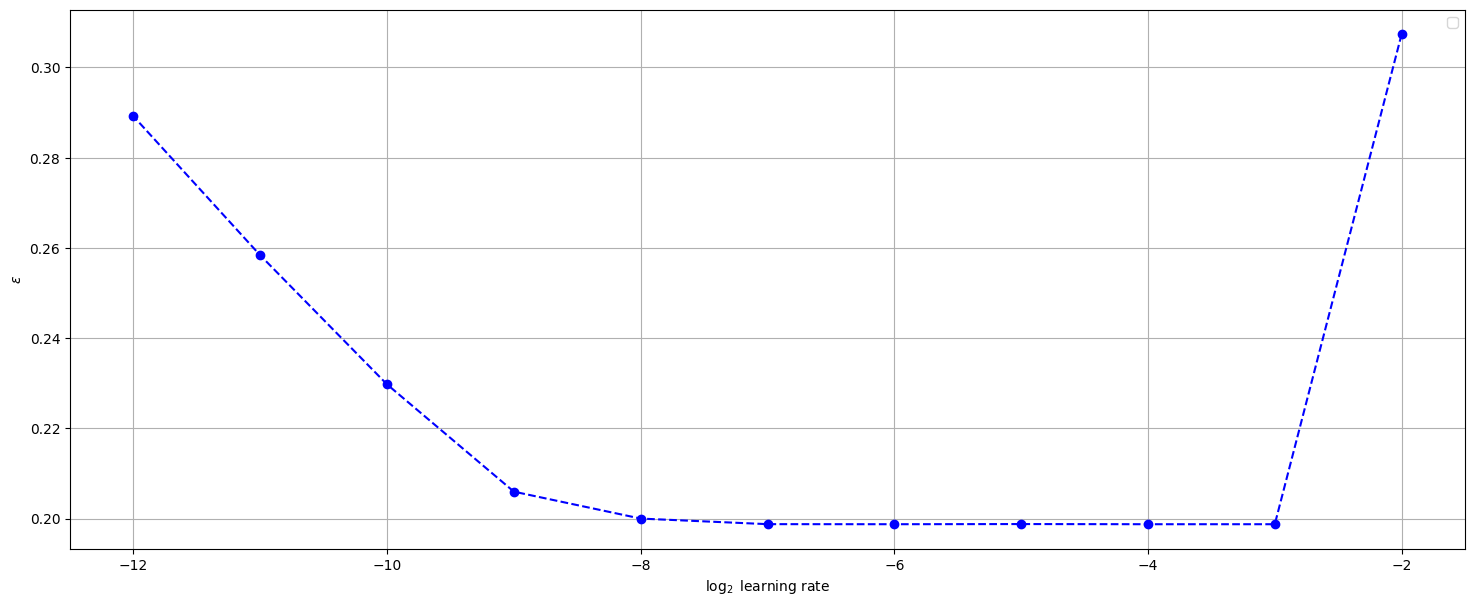

In [182]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list), torch.tensor(losses), '--bo')
plt.xlabel('$\\log_2$ learning rate')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

###Next, we tune stochastic gradient descent.

For stochastic gradient descent, we are using shrinking learning rate $\frac{\alpha}{T}$ for iteration $T$. We shall tune $\alpha$.

In [186]:
np.random.seed(8675309)
torch.manual_seed(8675309)

losses = []
for alpha in alpha_list:
    # train a model
    model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([0.1, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 8.0	 loss: 0.19877129793167114
alpha: 4.0	 loss: 0.19877386093139648
alpha: 2.0	 loss: 0.19880035519599915
alpha: 1.0	 loss: 0.19877669215202332
alpha: 0.5	 loss: 0.1996573805809021
alpha: 0.25	 loss: 0.2001848965883255
alpha: 0.125	 loss: 0.20198290050029755
alpha: 0.0625	 loss: 0.23564520478248596
alpha: 0.03125	 loss: 0.26620951294898987
alpha: 0.015625	 loss: 0.3019811511039734
alpha: 0.0078125	 loss: 0.31017348170280457
alpha: 0.00390625	 loss: 0.3359171748161316


From the plot, we see that $\alpha =1$ stably yields low loss.

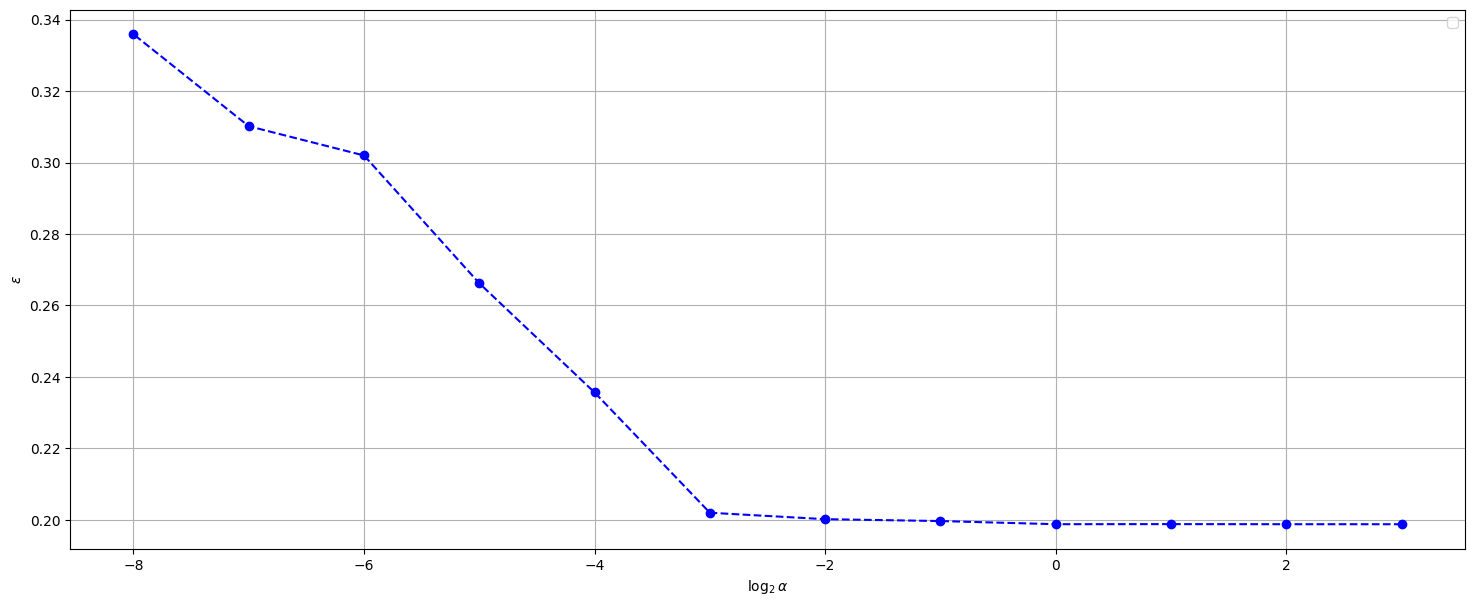

In [184]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), torch.tensor(losses), '--bo')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

## Compare Learning the Optimal Solution Path with Naive Grid Search

### Visualizing the solution path on a 2d synthetic dataset

In [84]:
lam_max = 1
lam_min = 0
num_grid = 2**10
epochs = 5000
lr = 0.5**4

In [85]:
#some synthetic data for instance below
np.random.seed(8675309)
torch.manual_seed(8675309) #Ensures linear layer initializes deterministically for reproducibility

X_syn, y_syn = my_logit.gen_data(100, 100, 2)

# beta_star = torch.from_numpy(beta_star) #useful to store as tensor for later

In [86]:
#The pytorch built-in binary cross-entropy loss
criterion = torch.nn.BCELoss()
input_dim_syn = X_syn.shape[1]

In [90]:
syn_data = my_logit.Regression_Data(X_syn, y_syn)
syn_data_loader = my_logit.DataLoader(syn_data, batch_size=len(syn_data), shuffle=False, )

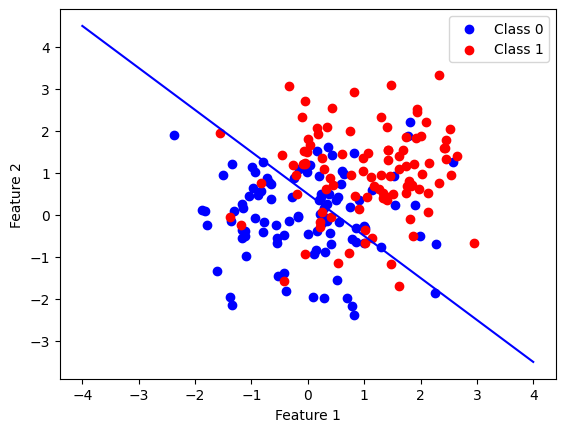

In [ ]:
# Separate data points by class
class_0 = X_syn[y_syn == 0]
class_1 = X_syn[y_syn == 1]

# Create a scatter plot
plt.scatter(class_0[:, 0], class_0[:, 1], c='b', marker='o', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], c='r', marker='o', label='Class 1')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')

# plot perfect separator
x_1 = np.linspace(-4, 4, 100)
x_2 = -x_1 + .5
plt.plot(x_1, x_2, color='blue')

# Show the plot
plt.show()

In [ ]:
models, num_itr = naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                    num_grid=num_grid, epochs=epochs,
                                    trainDataLoader=syn_data_loader,
                                    data_input_dim=input_dim_syn,
                                    lr=lr, SGD=False)

In [ ]:
thetas = []
for model in models:
    thetas.append(model.linear.weight.data.detach().numpy()[0])
thetas = np.array(thetas)
print(thetas.shape)

(1024, 2)


In [91]:
import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/syn_exact_soln_list.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['feature 1', 'feature 2'])

#     # Write the data from your lists
#     for i in range(len(thetas)):
#         csv_writer.writerow([thetas[i,0], thetas[i,1]])

In [111]:
import pandas as pd
csv_file_path = '/content/drive/MyDrive/Experiments/syn_exact_soln_list.csv'
thetas = pd.read_csv(csv_file_path)
thetas = np.array(thetas)

Text(0, 0.5, 'Feature 2')

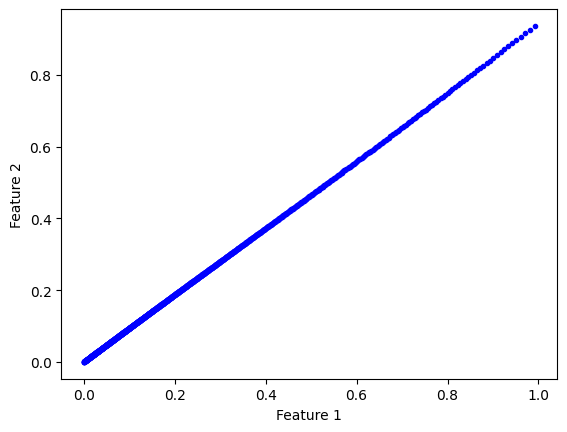

In [112]:
# Create a scatter plot
plt.scatter(thetas[:, 0], thetas[:, 1], c='b', marker='.', label='exact solution path')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

In [ ]:
exact_solns = []
for model in models:
    exact_solns.append(my_logit.test(syn_data_loader, model, criterion, model.reg_param))

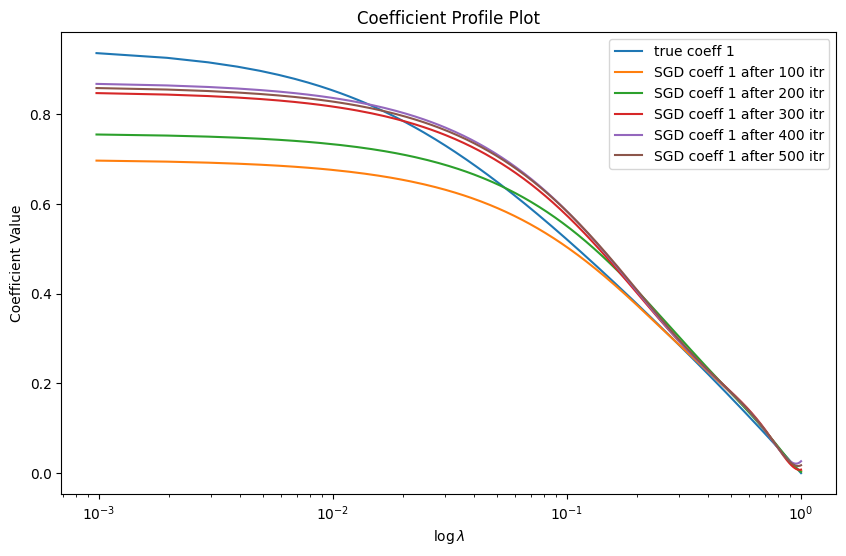

In [160]:
delta_lam = (lam_max - lam_min)/num_grid
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam).to(device)

# Create a Matplotlib plot
plt.figure(figsize=(10, 6))
plt.plot(lambdas, thetas[:,1], label=f'true coeff {1}')

# build the model
basis_dim = 5
epoch = 500
lr = 0.5**4
np.random.seed(8675309)
torch.manual_seed(8675309)
model = Basis_TF_SGD(input_dim_syn, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()

for t in range(epoch):
    train_SGD(syn_data_loader, model, criterion, optimizer)
    if (t+1) % 100 == 0:
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        # Plot coefficient profiles
        plt.plot(lambdas, thetas_SGD[:,1], label=f'SGD coeff {1} after {t+1} itr')


# Set plot labels and title
plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\log \\lambda$')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Profile Plot')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
basis_dim = 5
epoch = 500
lr = 0.5**4
np.random.seed(8675309)
torch.manual_seed(8675309)
model = Basis_TF_SGD(input_dim_syn, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()

for t in range(epoch):
    train_SGD(syn_data_loader, model, criterion, optimizer)

In [152]:
delta_lam = (lam_max - lam_min)/num_grid
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam).to(device)
thetas_SGD = []
for lam in lambdas:
    thetas_SGD.append(model(lam).data.detach().numpy())
thetas_SGD = np.array(thetas_SGD)

In [162]:
thetas_SGD[:, 0]

array([-0.02457257, -0.02402914, -0.0234919 , ..., -0.724197  ,
       -0.72847533, -0.7327739 ], dtype=float32)

Text(0, 0.5, 'Feature 2')

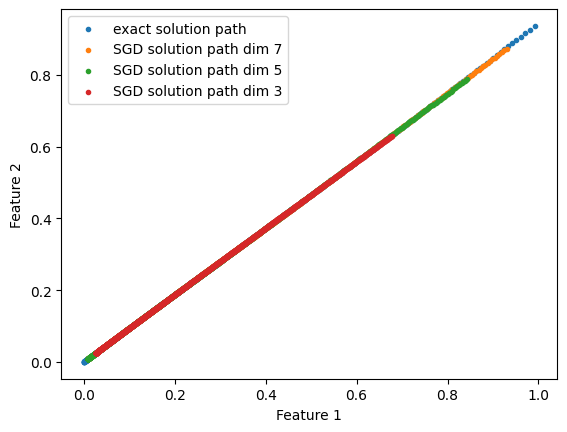

In [167]:
# Create a scatter plot
plt.scatter(thetas[:, 0], thetas[:, 1], marker='.', label='exact solution path')

epoch = 500
lr = 0.5**4

delta_lam = (lam_max - lam_min)/num_grid
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam).to(device)

np.random.seed(8675309)
torch.manual_seed(8675309)

for basis_dim in range(7, 2, -2):
    model = Basis_TF_SGD(input_dim_syn, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epoch):
        train_SGD(syn_data_loader, model, criterion, optimizer)

    thetas_SGD = []
    for lam in lambdas:
        thetas_SGD.append(model(lam).data.detach().numpy())
    thetas_SGD = np.array(thetas_SGD)
    plt.scatter(thetas_SGD[:, 1], thetas_SGD[:, 2], marker='.', label=f'SGD solution path dim {basis_dim}')

plt.legend()
# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

In [ ]:
norms = []
for i in range(len(lambdas)):
    norms.append(torch.tensor(thetas_SGD[i] - thetas[i]).norm(p=2))

Text(0, 0.5, '$\\|\\Phi(\\lambda)\\beta - \\theta^*(\\lambda)\\|$')

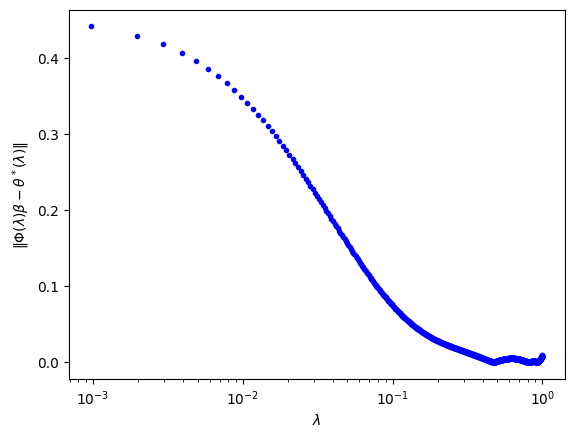

In [ ]:
# Create a scatter plot
plt.scatter(lambdas, norms, c='b', marker='.')
# Add labels and legend
plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$')
plt.ylabel('$\\|\\Phi(\lambda)\\beta - \\theta^*(\\lambda)\\|$')

### The Exact Solution Path

We use the Naive Grid Search with $2^10$ grids, trained by full gradient descent with learning rate = $2^{-4}$ and 5000 iterations on each grid, to generate an exact solution path.

In [ ]:
full_data = my_logit.Regression_Data(X, y)
# full gradient descent uses all data points
GD_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(full_data, batch_size=5, shuffle=True, )
# test data
test_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=False, )

In [ ]:
lam_max = torch.tensor(1).to(device)
lam_min = torch.tensor(0).to(device)
num_grid = 2**10
epochs = 5000
delta_lam = (lam_max - lam_min)/num_grid

In [ ]:
import csv
# a fine grid to simulate the exact solution path $\theta^*(\lambda)$
# delta_lam = (lam_max - lam_min)/num_grid
model_list = naive_grid_search(lam_min, lam_max, num_grid, epochs, GD_data_loader, 0.5**7)
sim_exact_soln_list = []
for model in model_list:
    sim_exact_soln_list.append(test(test_data_loader, model, criterion, model.reg_param))
print("---------exact solution path complete----------")
print(f"sim_exact_soln_list = {sim_exact_soln_list}")

csv_file_path = '/content/drive/MyDrive/exact_soln_list.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    # Create a CSV writer
    csv_writer = csv.writer(csv_file)

    # Write the headers
    csv_writer.writerow(['index', 'lambda', 'exact solution', 'weight'])

    # Write the data from your lists
    for i in range(len(sim_exact_soln_list)):
        model = model_list[i]
        csv_writer.writerow([i, model.reg_param, sim_exact_soln_list[i], model.linear.weight])

---------exact solution path complete----------
exact_soln_list = [0.0, 0.0006589088588953018, 0.0013274236116558313, 0.0020051177125424147, 0.002675686962902546, 0.0033023643773049116, 0.004017191007733345, 0.004619441460818052, 0.0052505116909742355, 0.00599596556276083, 0.006829672027379274, 0.007275688927620649, 0.007939117960631847, 0.008609271608293056, 0.009135077707469463, 0.009972370229661465, 0.010653996840119362, 0.01148739643394947, 0.011847238056361675, 0.012682001106441021, 0.013042540289461613, 0.013624906539916992, 0.014771164394915104, 0.014942798763513565, 0.016020141541957855, 0.016253748908638954, 0.016899729147553444, 0.017748601734638214, 0.018352989107370377, 0.018593931570649147, 0.019407998770475388, 0.01999870128929615, 0.020395010709762573, 0.021807633340358734, 0.021824495866894722, 0.022571923211216927, 0.023234156891703606, 0.024219907820224762, 0.02425558678805828, 0.02502424828708172, 0.02533802017569542, 0.02594400942325592, 0.027363307774066925, 0.0272

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###First, we plot the exact gradient case.

Learning the solution path:

Train the SGD model for our method using exact gradient and record the sup error along the solution path ($\epsilon$) achieved after executing some number of gradient calls (epochs).

We use the previously tuned learning rate $2^{-5}$.

In [ ]:
# build the model
basis_dim = torch.tensor(5).to(device)
max_epoch = torch.tensor(10000).to(device)
lr = torch.tensor(0.5 ** 5)
weight = torch.normal(0, 1, (1, input_dim))
model_GD = Logistic_Regression(input_dim*basis_dim, 1, 0, weight).to(device)# reg_param = 0 here is only a space holder
optimizer = torch.optim.SGD(model_GD.parameters(), lr=lr)
optimizer.zero_grad()

# prepare the sup error list
GD_error_list = []
epochs = []

# train the model
for t in range(max_epoch):
    train_SGD(GD_data_loader, model_GD, criterion, optimizer, basis_dim, trace_frequency=5)
    if (t + 1) % 100 == 0:
        print(f"---------approximate solution path for # epochs = {t+1} complete----------")

        epochs.append(t+1)
        sup_error = torch.tensor(0)
        for i in range(len(exact_soln_list)):

            lam = 1 - i * (0.5**10)
            approx_soln = test_SGD(test_data_loader, model_GD, criterion, basis_dim, lam)
            exact_soln = exact_soln_list[i]

            sup_error = torch.max(torch.tensor([sup_error, approx_soln - exact_soln]))
        print(f"epoch: {t+1}\t sup error: {sup_error}")
        GD_error_list.append(sup_error.item())

print(f"GD_error_list = {GD_error_list}")

---------approximate solution path for # epochs = 100 complete----------
epoch: 100	 sup error: 13.157889366149902
---------approximate solution path for # epochs = 200 complete----------
epoch: 200	 sup error: 2.8762335777282715
---------approximate solution path for # epochs = 300 complete----------
epoch: 300	 sup error: 1.4211149215698242
---------approximate solution path for # epochs = 400 complete----------
epoch: 400	 sup error: 0.7840641140937805
---------approximate solution path for # epochs = 500 complete----------
epoch: 500	 sup error: 0.39658719301223755
---------approximate solution path for # epochs = 600 complete----------
epoch: 600	 sup error: 0.21248792111873627
---------approximate solution path for # epochs = 700 complete----------
epoch: 700	 sup error: 0.10641106963157654
---------approximate solution path for # epochs = 800 complete----------
epoch: 800	 sup error: 0.052451759576797485
---------approximate solution path for # epochs = 900 complete----------
ep

In [ ]:
print(model_GD.linear.weight)

Parameter containing:
tensor([[-0.1002, -0.0762, -0.0999, -0.0941, -0.0425, -0.0532, -0.0816, -0.1018,
         -0.0335,  0.0308, -0.0757,  0.0046, -0.0672, -0.0676,  0.0079, -0.0014,
         -0.0029, -0.0368,  0.0150,  0.0238, -0.1121, -0.0915, -0.1093, -0.1006,
         -0.0728, -0.0676, -0.0846, -0.1121, -0.0709, -0.0360,  0.0739,  0.0649,
          0.0729,  0.0689,  0.0294,  0.0271,  0.0567,  0.0746,  0.0204, -0.0336,
          0.0592, -0.0039,  0.0495,  0.0506, -0.0024, -0.0147, -0.0087,  0.0210,
         -0.0157, -0.0305,  0.0856,  0.0805,  0.0821,  0.0756,  0.0607,  0.0435,
          0.0611,  0.0846,  0.0587,  0.0236, -0.0220, -0.0277, -0.0211, -0.0205,
         -0.0076,  0.0029, -0.0153, -0.0227, -0.0025,  0.0192, -0.0230,  0.0012,
         -0.0166, -0.0176, -0.0037,  0.0184,  0.0108, -0.0020,  0.0084,  0.0198,
         -0.0287, -0.0366, -0.0263, -0.0246, -0.0250, -0.0069, -0.0181, -0.0274,
         -0.0238, -0.0050,  0.0132,  0.0168,  0.0127,  0.0125,  0.0050, -0.0016,
      

In [ ]:
GD_error_list = [13.157889366149902, 2.8762335777282715, 1.4211149215698242, 0.7840641140937805, 0.39658719301223755, 0.21248792111873627, 0.10641106963157654, 0.052451759576797485, 0.0505622997879982, 0.043897777795791626, 0.042160749435424805, 0.04292033612728119, 0.049875348806381226, 0.046970807015895844, 0.045137494802474976, 0.04557044804096222, 0.04385925084352493, 0.047999270260334015, 0.04133377969264984, 0.04378370940685272, 0.04534165561199188, 0.04557458311319351, 0.043390192091464996, 0.044142283499240875, 0.04907400161027908, 0.04740063101053238, 0.048445649445056915, 0.04617734253406525, 0.05118115246295929, 0.05014089494943619, 0.047553159296512604, 0.04347892850637436, 0.04807686805725098, 0.04318372160196304, 0.044820450246334076, 0.045081980526447296, 0.04168855398893356, 0.04165542125701904, 0.04214140772819519, 0.04337218403816223, 0.0441485196352005, 0.04352450370788574, 0.04018837958574295, 0.0456201434135437, 0.0495639368891716, 0.049084797501564026, 0.04744754731655121, 0.048832401633262634, 0.045131996273994446, 0.044225290417671204, 0.04584105312824249, 0.044671110808849335, 0.043390944600105286, 0.04433178901672363, 0.04347408562898636, 0.04636774957180023, 0.04166005551815033, 0.04835046827793121, 0.047495558857917786, 0.04725336283445358, 0.04274836927652359, 0.044926613569259644, 0.04691261798143387, 0.04635941982269287, 0.04451605677604675, 0.04674284905195236, 0.04800253361463547, 0.04861226677894592, 0.0507567822933197, 0.052089542150497437, 0.05120781064033508, 0.050279006361961365, 0.04841117560863495, 0.04352760314941406, 0.039324015378952026, 0.04352618753910065, 0.04030001163482666, 0.04248589277267456, 0.039913587272167206, 0.0432424396276474, 0.045832157135009766, 0.0467640683054924, 0.04207204282283783, 0.042473070323467255, 0.04280978441238403, 0.040702491998672485, 0.0442022979259491, 0.04842153936624527, 0.050024598836898804, 0.05013994127511978, 0.05122809112071991, 0.04511886090040207, 0.04634302854537964, 0.04747060686349869, 0.04966982454061508, 0.047223448753356934, 0.04410222917795181, 0.04144924134016037, 0.043731868267059326, 0.04274150729179382]

In [ ]:
for i in range(len(GD_error_list)):
    GD_error_list[i] = torch.min(torch.tensor(GD_error_list[:i+1]))

In [ ]:
epochs = torch.arange(100, 10100, 100)

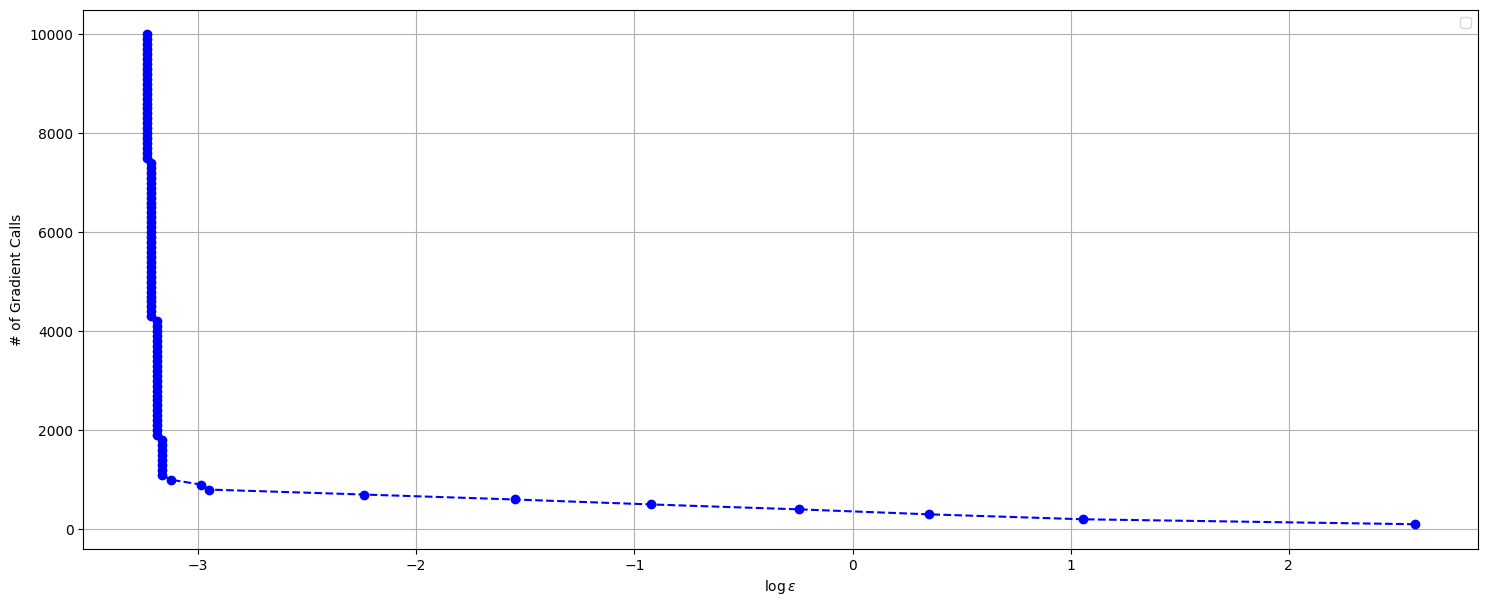

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(GD_error_list)), epochs, '--bo')
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

Naive Grid Search:

In [ ]:
lam_max = torch.tensor(1)
lam_min = torch.tensor(0)
lr = torch.tensor(0.5**7)
max_epochs = torch.tensor(5000)
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** torch.arange(2, 12)
print(delta_list)

tensor([0.2500, 0.1250, 0.0625, 0.0312, 0.0156, 0.0078, 0.0039, 0.0020, 0.0010,
        0.0005])


In [ ]:
total_itr_list = []
sup_error_list = []
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = torch.round(1 / torch.sqrt(delta))
    delta_lam = (lam_max - lam_min)/num_grid
    # create a list of lambda's
    lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam).to(device)

    model_list = []
    total_itr = 0

    # first weight is initialized with standard normal distribution
    # weight = torch.normal(0, 1, (1, input_dim))
    weight = torch.zeros(input_dim)

    for lam in lambdas:
        # build the model
        model = Logistic_Regression(input_dim, 1, lam, weight).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()

        # exact solution
        i = torch.round((1-lam) / (0.5**10)).int()
        if i >= len(exact_soln_list):
            i -= 1
            i.int()
        exact_soln = exact_soln_list[i]
        early_stop = False

        for t in range(max_epochs):
            train(GD_data_loader, model, criterion, optimizer, trace_frequency=5)

            if (t+1) % 10 == 0:
                # do an accuracy check
                approx_soln = test(test_data_loader, model, criterion, lam)
                error = approx_soln - exact_soln
                # stopping criterion
                if error <= delta:
                    total_itr += (t+1)
                    early_stop = True
                    break  # Early stop

        if not early_stop:
            total_itr += max_epochs

        weight = model.linear.weight
        model_list.append(model)

    total_itr_list.append(total_itr)

    # check sup error
    sup_error = 0
    for i in range(len(exact_soln_list)):
        exact_soln = exact_soln_list[i]
        coarse_grid = torch.round(i * (0.5**10) / delta_lam).int()
        if coarse_grid >= len(model_list):
            coarse_grid -= 1
            coarse_grid.int()
        # print(i, coarse_grid)
        temp = 1 - i * (0.5**10)
        # approximate solution uses the linear weight of coarse grid model to test for regression parameter of the fine grid
        approx_soln = test(test_data_loader, model_list[coarse_grid], criterion, temp)
        sup_error = torch.max(torch.tensor([sup_error, approx_soln - exact_soln]))
        # print(sup_error)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}")
    sup_error_list.append(sup_error.item())

print(f"total_itr_list = {total_itr_list}")
print(f"sup_error_list = {sup_error_list}")

grid #: 2.0	 total iteration #: 20	 sup error: 0.5443418025970459
grid #: 3.0	 total iteration #: 40	 sup error: 0.44806069135665894
grid #: 4.0	 total iteration #: 90	 sup error: 0.31780725717544556
grid #: 6.0	 total iteration #: 200	 sup error: 0.22405081987380981
grid #: 8.0	 total iteration #: 930	 sup error: 0.15703465044498444
grid #: 11.0	 total iteration #: 4450	 sup error: 0.11251042783260345
grid #: 16.0	 total iteration #: 12750	 sup error: 0.08494053781032562
grid #: 23.0	 total iteration #: 30880	 sup error: 0.06531494855880737
grid #: 32.0	 total iteration #: 59420	 sup error: 0.05156104266643524
grid #: 45.0	 total iteration #: 114900	 sup error: 0.04080396145582199
total_itr_list = [20, 40, 90, 200, 930, 4450, 12750, 30880, 59420, tensor(114900)]
sup_error_list = [0.5443418025970459, 0.44806069135665894, 0.31780725717544556, 0.22405081987380981, 0.15703465044498444, 0.11251042783260345, 0.08494053781032562, 0.06531494855880737, 0.05156104266643524, 0.04080396145582199]

In [ ]:
for i in range(len(sup_error_list)):
    sup_error_list[i] = torch.min(torch.tensor(sup_error_list[:i+1]))

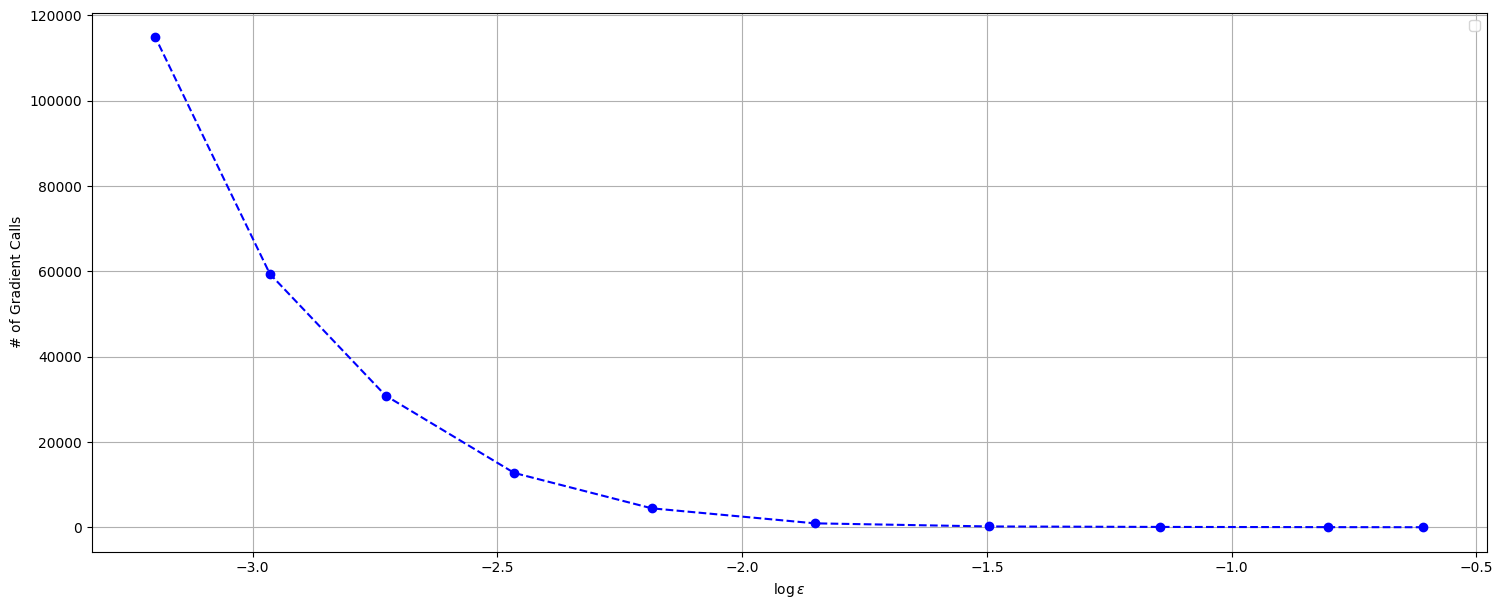

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(sup_error_list)), total_itr_list, '--bo')
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

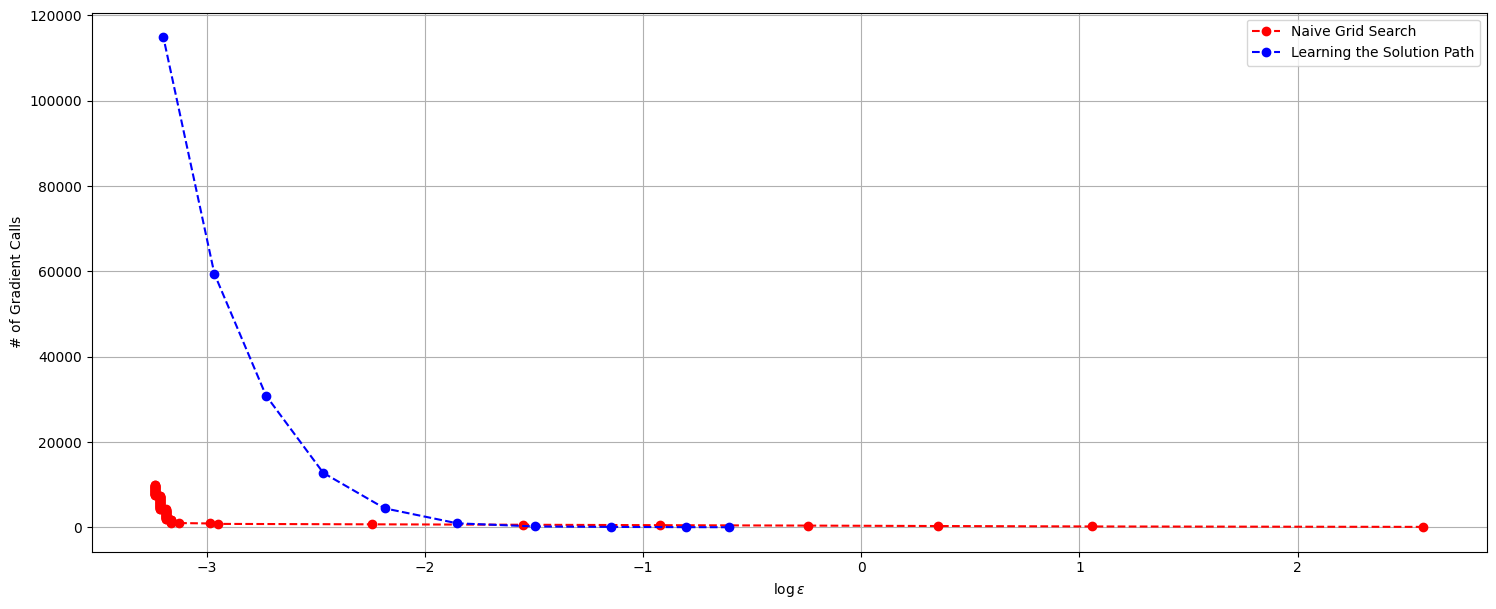

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(GD_error_list)), epochs, '--ro', label = f"Naive Grid Search")
plt.plot(torch.log(torch.tensor(sup_error_list)), total_itr_list, '--bo', label = f"Learning the Solution Path")
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

###Then, we plot the noisy gradient case.

Learning the solution path:

Train the SGD model for our method using noisy gradient (mini-batch SGD) and record the sup error along the solution path ($\epsilon$) achieved after executing some number of gradient calls (epochs).

We use the previously tuned shrinking rate.

In [ ]:
# build the model
basis_dim = torch.tensor(3).to(device)
max_epoch = torch.tensor(2000).to(device)
alpha = torch.tensor(4)
weight = torch.normal(0, 1, (1, input_dim*basis_dim))
model_SGD = Logistic_Regression(input_dim*basis_dim, 1, 0, weight).to(device)# reg_param = 0 here is only a space holder
optimizer = torch.optim.SGD(model_SGD.parameters(), lr=0.1)
optimizer.zero_grad()

# prepare the sup error list
SGD_error_list = []
epochs = []

# train the model
for t in range(max_epoch):
    # shrink learning rate
    lr = torch.min(torch.tensor([0.1, alpha/(t+1)]))
    # lr = 1/(t+1)
    # print(lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    train_SGD(SGD_data_loader, model_SGD, criterion, optimizer, basis_dim)
    if (t + 1) % 1 == 0:
    #     print(f"---------approximate solution path for # epochs = {t+1} complete----------")

        epochs.append(t+1)
        sup_error = 0
        for i in range(len(exact_soln_list)):

            lam = 1 - i * (0.5**10)
            approx_soln = test_SGD(test_data_loader, model_SGD, criterion, basis_dim, lam)
            exact_soln = exact_soln_list[i]

            sup_error = torch.max(torch.tensor([sup_error, approx_soln - exact_soln]))
        print(f"epoch: {t+1}\t sup error: {sup_error}")
        SGD_error_list.append(sup_error.item())

print(f"SGD_error_list = {SGD_error_list}")

epoch: 1	 sup error: 0.10758784413337708
epoch: 2	 sup error: 0.08267804980278015
epoch: 3	 sup error: 0.10423275828361511
epoch: 4	 sup error: 0.11874662339687347
epoch: 5	 sup error: 0.07293973863124847
epoch: 6	 sup error: 0.08950690925121307
epoch: 7	 sup error: 0.12418834865093231
epoch: 8	 sup error: 0.11435191333293915
epoch: 9	 sup error: 0.10676412284374237
epoch: 10	 sup error: 0.10984589159488678
epoch: 11	 sup error: 0.08286111056804657
epoch: 12	 sup error: 0.1041778177022934
epoch: 13	 sup error: 0.0695519745349884
epoch: 14	 sup error: 0.0947776734828949
epoch: 15	 sup error: 0.101585254073143
epoch: 16	 sup error: 0.08212156593799591
epoch: 17	 sup error: 0.09460850059986115
epoch: 18	 sup error: 0.08405698835849762
epoch: 19	 sup error: 0.10560815036296844
epoch: 20	 sup error: 0.10261088609695435
epoch: 21	 sup error: 0.06363475322723389
epoch: 22	 sup error: 0.07827155292034149
epoch: 23	 sup error: 0.5225872993469238
epoch: 24	 sup error: 0.08365835249423981
epoch: 

In [ ]:
SGD_error_list = [0.10758784413337708, 0.08267804980278015, 0.10423275828361511, 0.11874662339687347, 0.07293973863124847, 0.08950690925121307, 0.12418834865093231, 0.11435191333293915, 0.10676412284374237, 0.10984589159488678, 0.08286111056804657, 0.1041778177022934, 0.0695519745349884, 0.0947776734828949, 0.101585254073143, 0.08212156593799591, 0.09460850059986115, 0.08405698835849762, 0.10560815036296844, 0.10261088609695435, 0.06363475322723389, 0.07827155292034149, 0.5225872993469238, 0.08365835249423981, 0.12848909199237823, 0.11333905160427094, 0.07385502755641937, 0.09834854304790497, 0.09004780650138855, 0.08083368837833405, 0.08489155769348145, 0.0919848084449768, 0.09549763798713684, 0.09176811575889587, 0.08838993310928345, 0.10587891936302185, 0.09236526489257812, 0.10041254758834839, 0.3114033639431, 0.08860090374946594, 0.09843789041042328, 0.11762480437755585, 0.09050384163856506, 0.0802525132894516, 0.11756087839603424, 0.0928926020860672, 0.08371381461620331, 0.08632802963256836, 0.10329723358154297, 0.09570309519767761, 0.0777205377817154, 0.09403279423713684, 0.08947284519672394, 0.09031683206558228, 0.07617603242397308, 0.10883748531341553, 0.06798931956291199, 0.0946957916021347, 0.0821618139743805, 0.11563068628311157, 0.07902400195598602, 0.0727907121181488, 0.08992601931095123, 0.09843851625919342, 0.08642725646495819, 0.08486393094062805, 0.10057079792022705, 0.08633653819561005, 0.09316910803318024, 0.09148052334785461, 0.10131573677062988, 0.12086381018161774, 0.08991686999797821, 0.08839307725429535, 0.09837861359119415, 0.07757385075092316, 0.07101356983184814, 0.09918271005153656, 0.08884501457214355, 0.08683271706104279, 0.07402612268924713, 0.0776696503162384, 0.08683915436267853, 0.07445493340492249, 0.08792856335639954, 0.07811753451824188, 0.11454790830612183, 0.08759845793247223, 0.07150068879127502, 0.09156538546085358, 0.10871930420398712, 0.07429777085781097, 0.0866619199514389, 0.08950679004192352, 0.07541164755821228, 0.09579688310623169, 0.08015464246273041, 0.09221640229225159, 0.09407688677310944, 0.09024262428283691, 0.07595282793045044, 0.08331643044948578, 0.08030641078948975, 0.09391184151172638, 0.10271365940570831, 0.09879474341869354, 0.09285393357276917, 0.08134150505065918, 0.07238958775997162, 0.08798697590827942, 0.10038849711418152, 0.09529606997966766, 0.07212884724140167, 0.09181469678878784, 0.08873654901981354, 0.08145222067832947, 0.08653305470943451, 0.08177904784679413, 0.0777435451745987, 0.08653748035430908, 0.08751414716243744, 0.0977899432182312, 0.08442747592926025, 0.0951324850320816, 0.08185364305973053, 0.07818178832530975, 0.08338415622711182, 0.08532959222793579, 0.09791941940784454, 0.08424785733222961, 0.08720852434635162, 0.09550006687641144, 0.0808931291103363, 0.08769717812538147, 0.07793773710727692, 0.0820116400718689, 0.09197825193405151, 0.08508114516735077, 0.08484311401844025, 0.08528982102870941, 0.0869763046503067, 0.08714394271373749, 0.07986116409301758, 0.08566741645336151, 0.08552592992782593, 0.07706749439239502, 0.07964378595352173, 0.07693171501159668, 0.07922045886516571, 0.08834479749202728, 0.08421817421913147, 0.0815308541059494, 0.08187542855739594, 0.08180533349514008, 0.07417838275432587, 0.08433078229427338, 0.09106756746768951, 0.08040112257003784, 0.09001104533672333, 0.09329363703727722, 0.09045496582984924, 0.08072209358215332, 0.07802167534828186, 0.07898101210594177, 0.08402009308338165, 0.08520747721195221, 0.09022291004657745, 0.09464402496814728, 0.08402039110660553, 0.08054278790950775, 0.08086910843849182, 0.08923806250095367, 0.09927728772163391, 0.08687739074230194, 0.0822678804397583, 0.09071046113967896, 0.08655640482902527, 0.08963029086589813, 0.0910039097070694, 0.09482015669345856, 0.07807271182537079, 0.08649739623069763, 0.08850397169589996, 0.09131284058094025, 0.08979521691799164, 0.08376546204090118, 0.08480092883110046, 0.08794312179088593, 0.08159533143043518, 0.07993611693382263, 0.0876801460981369, 0.0965440422296524, 0.09114211797714233, 0.08189716935157776, 0.07934717833995819, 0.08188687264919281, 0.08079427480697632, 0.08309265971183777, 0.08900965750217438, 0.08730070292949677, 0.09330369532108307, 0.0768083781003952, 0.07651937007904053, 0.08493886888027191, 0.08576521277427673, 0.08014167845249176, 0.08760333061218262, 0.0782804787158966, 0.08409194648265839, 0.08011482656002045, 0.07416945695877075, 0.081637904047966, 0.07920369505882263, 0.08113043010234833, 0.08165711164474487, 0.08460827171802521, 0.08484208583831787, 0.08077046275138855, 0.08059225976467133, 0.08452613651752472, 0.09016895294189453, 0.08988036215305328, 0.08171902596950531, 0.08035451173782349, 0.07838691771030426, 0.08294416964054108, 0.08783924579620361, 0.08631692826747894, 0.08477760851383209, 0.091393381357193, 0.09985941648483276, 0.08812697231769562, 0.0879206508398056, 0.08125349879264832, 0.08541826903820038, 0.09299848973751068, 0.08819472789764404, 0.0889594703912735, 0.0876230001449585, 0.09096278250217438, 0.09234212338924408, 0.08056077361106873, 0.07992540299892426, 0.07793910801410675, 0.07527847588062286, 0.08299647271633148, 0.07512472569942474, 0.08214204013347626, 0.07810153067111969, 0.08654515445232391, 0.08177512884140015, 0.08124233782291412, 0.08353327214717865, 0.08865329623222351, 0.08411438763141632, 0.08450157940387726, 0.08481106162071228, 0.08036099374294281, 0.08045405149459839, 0.07987914979457855, 0.07991066575050354, 0.08257022500038147, 0.08559824526309967, 0.07369151711463928, 0.08513905107975006, 0.08555185794830322, 0.08669516444206238, 0.08953911066055298, 0.08424609899520874, 0.08112551271915436, 0.0817147046327591, 0.07628646492958069, 0.08604049682617188, 0.08429987728595734, 0.08018355071544647, 0.08004379272460938, 0.0818970650434494, 0.07747754454612732, 0.08468809723854065, 0.07888638973236084, 0.08490696549415588, 0.08391585946083069, 0.0835128128528595, 0.0841672271490097, 0.07999338209629059, 0.08169505000114441, 0.08515633642673492, 0.08822649717330933, 0.09596990048885345, 0.0922502726316452, 0.08703410625457764, 0.0946417897939682, 0.0836944580078125, 0.08220009505748749, 0.0897965282201767, 0.08825433254241943, 0.08331701159477234, 0.08640274405479431, 0.08771273493766785, 0.08651384711265564, 0.08947664499282837, 0.09099198877811432, 0.0837613046169281, 0.08515357971191406, 0.08927091956138611, 0.09041771292686462, 0.08427222073078156, 0.07772789895534515, 0.07968033850193024, 0.08502370119094849, 0.0836140513420105, 0.08094500005245209, 0.08430182933807373, 0.08493906259536743, 0.08765628933906555, 0.09188660979270935, 0.08814798295497894, 0.0891619622707367, 0.09144775569438934, 0.08069337904453278, 0.08233575522899628, 0.08519500494003296, 0.07877647876739502, 0.08413320779800415, 0.0819217711687088, 0.08443441987037659, 0.08669590950012207, 0.08410181105136871, 0.07972277700901031, 0.0897568017244339, 0.08555285632610321, 0.07994149625301361, 0.08384482562541962, 0.08181211352348328, 0.07935461401939392, 0.0870550125837326, 0.08807988464832306, 0.08140937983989716, 0.08614006638526917, 0.08282814919948578, 0.08683629333972931, 0.08487546443939209, 0.09145809710025787, 0.08559511601924896, 0.0870300680398941, 0.08120663464069366, 0.08067236840724945, 0.08106455206871033, 0.08689416944980621, 0.07811425626277924, 0.07717497646808624, 0.07642699778079987, 0.08361373841762543, 0.08241006731987, 0.0814816802740097, 0.08183500170707703, 0.08041492104530334, 0.08879011869430542, 0.0803065150976181, 0.0805332362651825, 0.08093051612377167, 0.07931138575077057, 0.07903409004211426, 0.08565555512905121, 0.08722880482673645, 0.08547697961330414, 0.0835866928100586, 0.08479778468608856, 0.08027686178684235, 0.0812177062034607, 0.08852168917655945, 0.08839868009090424, 0.09027260541915894, 0.08466020226478577, 0.0833938717842102, 0.08065561950206757, 0.08196507394313812, 0.0886816531419754, 0.08995138108730316, 0.08419038355350494, 0.0838373601436615, 0.08755695819854736, 0.08252483606338501, 0.08638845384120941, 0.08220024406909943, 0.08011819422245026, 0.07593148946762085, 0.07673954963684082, 0.08052249252796173, 0.08225883543491364, 0.08117334544658661, 0.08062389492988586, 0.0825338214635849, 0.08585487306118011, 0.08986388146877289, 0.0827607661485672, 0.08866091072559357, 0.08186724781990051, 0.0843888521194458, 0.08602377772331238, 0.08170278370380402, 0.0864247977733612, 0.07545119524002075, 0.07862807810306549, 0.08050329983234406, 0.08690974116325378, 0.0934360921382904, 0.08573435246944427, 0.08668068051338196, 0.08226917684078217, 0.0811266154050827, 0.08760765194892883, 0.09059952199459076, 0.0896325409412384, 0.08037576079368591, 0.0828925222158432, 0.07829765975475311, 0.08132767677307129, 0.08173252642154694, 0.08041618764400482, 0.08050593733787537, 0.08031345903873444, 0.08322733640670776, 0.08223472535610199, 0.09009723365306854, 0.08686776459217072, 0.07894815504550934, 0.08204329013824463, 0.07778003811836243, 0.07685954868793488, 0.07739035785198212, 0.08121472597122192, 0.08286093175411224, 0.08360284566879272, 0.08012959361076355, 0.08489127457141876, 0.08256195485591888, 0.08263528347015381, 0.08471859991550446, 0.0822962075471878, 0.08747364580631256, 0.09158392250537872, 0.0823487788438797, 0.08298201858997345, 0.08308292925357819, 0.08056734502315521, 0.07947899401187897, 0.08250346779823303, 0.08263003826141357, 0.09154532849788666, 0.08778466284275055, 0.08635739982128143, 0.08527122437953949, 0.08030961453914642, 0.08530522882938385, 0.08197301626205444, 0.08240137994289398, 0.08543913066387177, 0.08559563755989075, 0.08324770629405975, 0.08834335207939148, 0.0853528380393982, 0.08413064479827881, 0.08132453262805939, 0.08389732241630554, 0.08687999844551086, 0.08777055144309998, 0.0900535136461258, 0.08404625952243805, 0.08363987505435944, 0.08701151609420776, 0.08557334542274475, 0.08510442078113556, 0.0852048397064209, 0.08284315466880798, 0.08856044709682465, 0.08424870669841766, 0.08474180102348328, 0.08291631937026978, 0.08091534674167633, 0.0832563191652298, 0.08205847442150116, 0.08367127180099487, 0.08643436431884766, 0.08412213623523712, 0.083092600107193, 0.08036790788173676, 0.0872456282377243, 0.08745205402374268, 0.08852891623973846, 0.08753898739814758, 0.0904054194688797, 0.08670002222061157, 0.08570605516433716, 0.08222216367721558, 0.08229605853557587, 0.08419696986675262, 0.08093123137950897, 0.07827730476856232, 0.07907524704933167, 0.0780859887599945, 0.08231127262115479, 0.08490234613418579, 0.08666934072971344, 0.09137330949306488, 0.09324133396148682, 0.08974018692970276, 0.08190104365348816, 0.08386535942554474, 0.08215805888175964, 0.07972607016563416, 0.08201353251934052, 0.08060339093208313, 0.08185014128684998, 0.08242863416671753, 0.07977098226547241, 0.0797322690486908, 0.07949762046337128, 0.08163687586784363, 0.08267872035503387, 0.08220647275447845, 0.08166390657424927, 0.08452410995960236, 0.08657588064670563, 0.08296142518520355, 0.08270621299743652, 0.08450911939144135, 0.08476682007312775, 0.08366861939430237, 0.08408062160015106, 0.08267872035503387, 0.0843224823474884, 0.08551160991191864, 0.08281084895133972, 0.08579324185848236, 0.08682486414909363, 0.0834256261587143, 0.08086900413036346, 0.07990023493766785, 0.08289369940757751, 0.08397878706455231, 0.08482953906059265, 0.08457109332084656, 0.08230817317962646, 0.081234872341156, 0.08425799012184143, 0.08518324792385101, 0.08504265546798706, 0.08628302812576294, 0.08497296273708344, 0.08484591543674469, 0.0844646692276001, 0.08047275245189667, 0.07941056787967682, 0.08289766311645508, 0.08424390852451324, 0.08401015400886536, 0.08574922382831573, 0.08432720601558685, 0.0855635404586792, 0.08106541633605957, 0.08069908618927002, 0.0799972414970398, 0.08394721150398254, 0.08537611365318298, 0.08373872935771942, 0.07834956049919128, 0.08397799730300903, 0.08141672611236572, 0.08161760866641998, 0.08430083096027374, 0.0817280262708664, 0.0810696929693222, 0.07981942594051361, 0.08506384491920471, 0.08287186920642853, 0.08343082666397095, 0.08644610643386841, 0.08745801448822021, 0.0867173820734024, 0.08371467888355255, 0.08296987414360046, 0.08241644501686096, 0.08431178331375122, 0.08695483207702637, 0.08530376851558685, 0.08459623157978058, 0.08402156829833984, 0.08777649700641632, 0.08254091441631317, 0.08149346709251404, 0.07944905757904053, 0.08028969168663025, 0.07988300919532776, 0.0815066546201706, 0.08302183449268341, 0.08138297498226166, 0.08188840746879578, 0.08452065289020538, 0.08488152921199799, 0.0823640525341034, 0.08805587887763977, 0.08473791182041168, 0.07966403663158417, 0.07796350121498108, 0.0798218697309494, 0.08015784621238708, 0.08420544862747192, 0.08373256027698517, 0.08481580018997192, 0.08397123217582703, 0.08479991555213928, 0.08346416056156158, 0.083493173122406, 0.08385749161243439, 0.08221320807933807, 0.08143845200538635, 0.08336105942726135, 0.08635099232196808, 0.08783793449401855, 0.08492663502693176, 0.0813046544790268, 0.08234237134456635, 0.0829438865184784, 0.08392146229743958, 0.08045800030231476, 0.08355298638343811, 0.08440525829792023, 0.08325181901454926, 0.08015839755535126, 0.0826709121465683, 0.08209912478923798, 0.0843614786863327, 0.08229969441890717, 0.08163110911846161, 0.07993337512016296, 0.07965482771396637, 0.08247633278369904, 0.08424915373325348, 0.08119896054267883, 0.0821925699710846, 0.078545942902565, 0.0771610289812088, 0.08082818984985352, 0.07928259670734406, 0.07851280272006989, 0.0826539695262909, 0.08170481026172638, 0.07693801820278168, 0.0773731917142868, 0.07853229343891144, 0.07698613405227661, 0.07955677807331085, 0.0802963525056839, 0.08140634000301361, 0.08596144616603851, 0.08495445549488068, 0.084769606590271, 0.08152006566524506, 0.08253732323646545, 0.08501465618610382, 0.08700533211231232, 0.08629301190376282, 0.08444614708423615, 0.08665558695793152, 0.08332666754722595, 0.08285638689994812, 0.08542761206626892, 0.0796147882938385, 0.08070050179958344, 0.08107489347457886, 0.08053064346313477, 0.08168946206569672, 0.08356572687625885, 0.08332251012325287, 0.08147257566452026, 0.078707754611969, 0.07886838912963867, 0.08149154484272003, 0.08151838183403015, 0.08377136290073395, 0.08481588959693909, 0.07717633247375488, 0.0795769989490509, 0.07923801243305206, 0.08011674880981445, 0.078902468085289, 0.07965047657489777, 0.07988601922988892, 0.082939013838768, 0.08527873456478119, 0.08651483058929443, 0.08837549388408661, 0.08913889527320862, 0.08736880123615265, 0.0858948826789856, 0.08710049092769623, 0.08452948927879333, 0.0853189080953598, 0.08706991374492645, 0.0825750082731247, 0.08153949677944183, 0.0805317759513855, 0.08129642903804779, 0.08221414685249329, 0.08446747064590454, 0.08533594012260437, 0.08452777564525604, 0.08613833785057068, 0.08305943012237549, 0.08188866078853607, 0.08821868896484375, 0.08106724917888641, 0.08186741173267365, 0.08366404473781586, 0.08365511894226074, 0.08422689139842987, 0.08567038178443909, 0.08146217465400696, 0.0841081291437149, 0.08421075344085693, 0.07931801676750183, 0.08239632844924927, 0.08110643923282623, 0.08147472143173218, 0.08251361548900604, 0.08343753218650818, 0.08159501850605011, 0.08087010681629181, 0.08038297295570374, 0.08279585838317871, 0.0810679942369461, 0.08184285461902618, 0.08289243280887604, 0.08360396325588226, 0.08383160829544067, 0.08291472494602203, 0.08281707763671875, 0.08352386951446533, 0.08309245109558105, 0.08271312713623047, 0.0808381736278534, 0.08061939477920532, 0.0839117169380188, 0.08420515060424805, 0.08634881675243378, 0.08731701970100403, 0.08283443748950958, 0.08076956868171692, 0.08255958557128906, 0.08381898701190948, 0.08226223289966583, 0.08357752859592438, 0.07849179208278656, 0.082247793674469, 0.082978755235672, 0.08602024614810944, 0.08242648839950562, 0.0827445387840271, 0.08198876678943634, 0.08237282931804657, 0.08397984504699707, 0.08469544351100922, 0.08573053777217865, 0.08457149565219879, 0.0848093032836914, 0.08588819205760956, 0.08735030889511108, 0.0841328501701355, 0.08635641634464264, 0.08648769557476044, 0.08576920628547668, 0.08789610862731934, 0.08516110479831696, 0.08221739530563354, 0.08559547364711761, 0.08591809868812561, 0.0858822762966156, 0.08193157613277435, 0.07708114385604858, 0.08227740228176117, 0.08552926778793335, 0.08518503606319427, 0.08546848595142365, 0.08637358248233795, 0.08785255253314972, 0.08739741146564484, 0.08717307448387146, 0.0875546783208847, 0.08619439601898193, 0.08744357526302338, 0.08300206065177917, 0.08051645755767822, 0.08329778909683228, 0.08240942656993866, 0.08266083896160126, 0.08012141287326813, 0.08143708109855652, 0.08028014004230499, 0.08265961706638336, 0.08261680603027344, 0.08445361256599426, 0.08263203501701355, 0.08345767855644226, 0.0824510008096695, 0.08118188381195068, 0.0835815817117691, 0.08563879132270813, 0.08376476168632507, 0.08403272926807404, 0.08588087558746338, 0.08641979098320007, 0.08459645509719849, 0.08417117595672607, 0.08397302031517029, 0.08171796798706055, 0.08427323400974274, 0.08354176580905914, 0.08341696858406067, 0.08523337543010712, 0.0860009491443634, 0.08637690544128418, 0.08537346124649048, 0.08452469110488892, 0.08286675810813904, 0.08180218935012817, 0.08291476964950562, 0.08278067409992218, 0.08207517862319946, 0.08345790207386017, 0.08412788808345795, 0.08111521601676941, 0.08325839042663574, 0.08438415825366974, 0.08448648452758789, 0.08702944219112396, 0.08958229422569275, 0.08710038661956787, 0.08732359111309052, 0.08729653060436249, 0.08296209573745728, 0.08444906771183014, 0.08485960960388184, 0.08165577054023743, 0.08289049565792084, 0.08204680681228638, 0.08178147673606873, 0.07926705479621887, 0.08106167614459991, 0.08505204319953918, 0.08593209087848663, 0.08333028852939606, 0.08330368995666504, 0.0840892642736435, 0.0834973156452179, 0.08498726785182953, 0.084912970662117, 0.08617772161960602, 0.08563661575317383, 0.08462615311145782, 0.08750781416893005, 0.08912481367588043, 0.08931399881839752, 0.08168131113052368, 0.08516983687877655, 0.08457085490226746, 0.07990513741970062, 0.0801117867231369, 0.07997293770313263, 0.08130225539207458, 0.08197256922721863, 0.08139818906784058, 0.08080340921878815, 0.08097627758979797, 0.08079342544078827, 0.08273544907569885, 0.0842536985874176, 0.08549897372722626, 0.08641575276851654, 0.08419868350028992, 0.08674398064613342, 0.08599255979061127, 0.08371749520301819, 0.08499252796173096, 0.0850365161895752, 0.08561618626117706, 0.08622422814369202, 0.08170479536056519, 0.08000761270523071, 0.08059926331043243, 0.07891358435153961, 0.08033932745456696, 0.08207505941390991, 0.08129949867725372, 0.0838484913110733, 0.08275006711483002, 0.08501936495304108, 0.08336438238620758, 0.08389082551002502, 0.08540727198123932, 0.08269470930099487, 0.0843338668346405, 0.08459609746932983, 0.08423586189746857, 0.08200396597385406, 0.0817623883485794, 0.08438445627689362, 0.0839303731918335, 0.085324227809906, 0.0866420716047287, 0.08280977606773376, 0.08467830717563629, 0.0826224684715271, 0.08586975932121277, 0.08638244867324829, 0.0857594758272171, 0.08606724441051483, 0.08404554426670074, 0.08562995493412018, 0.08256836235523224, 0.08294656872749329, 0.08540631830692291, 0.08393195271492004, 0.08303125202655792, 0.08194093406200409, 0.08127996325492859, 0.08271680772304535, 0.08234140276908875, 0.08210331201553345, 0.08118736743927002, 0.08138500154018402, 0.08115178346633911, 0.08044710755348206, 0.07863180339336395, 0.08003251254558563, 0.08156676590442657, 0.08290338516235352, 0.08407235145568848, 0.08500814437866211, 0.08661356568336487, 0.08532992005348206, 0.08632580935955048, 0.0861908495426178, 0.08341503143310547, 0.08407802879810333, 0.08356700837612152, 0.0850830078125, 0.08344411849975586, 0.08505783975124359, 0.0837274044752121, 0.0839245617389679, 0.08174309134483337, 0.08551013469696045, 0.08391669392585754, 0.0784493088722229, 0.07855866849422455, 0.0814414918422699, 0.08341051638126373, 0.08319702744483948, 0.08403770625591278, 0.08460108935832977, 0.08238133788108826, 0.08361901342868805, 0.0837123841047287, 0.08038139343261719, 0.08023428916931152, 0.08163543045520782, 0.08211445808410645, 0.08002427220344543, 0.0796995609998703, 0.08196476101875305, 0.08418956398963928, 0.08361311256885529, 0.08452180027961731, 0.08662624657154083, 0.08150981366634369, 0.07995198667049408, 0.07950563728809357, 0.07970887422561646, 0.08049781620502472, 0.08001108467578888, 0.08001500368118286, 0.07855549454689026, 0.07995320856571198, 0.08043050765991211, 0.08079148828983307, 0.08307421207427979, 0.08381733298301697, 0.08300398290157318, 0.0821562111377716, 0.08130869269371033, 0.08287787437438965, 0.08525161445140839, 0.08411164581775665, 0.08275480568408966, 0.07967129349708557, 0.08189310133457184, 0.08562695980072021, 0.08367685973644257, 0.08642970025539398, 0.08803512156009674, 0.0834820568561554, 0.08299638330936432, 0.08428546786308289, 0.08562865853309631, 0.0870792418718338, 0.08594948053359985, 0.08401651680469513, 0.08471508324146271, 0.08282816410064697, 0.0818827897310257, 0.08341018855571747, 0.08459839224815369, 0.08511093258857727, 0.08355246484279633, 0.08069644868373871, 0.08050662279129028, 0.08288806676864624, 0.0841054618358612, 0.08383980393409729, 0.08532945811748505, 0.08744025230407715, 0.0844796746969223, 0.08499854803085327, 0.08603641390800476, 0.08529889583587646, 0.08274057507514954, 0.0817931592464447, 0.08307306468486786, 0.0840015709400177, 0.08075635135173798, 0.08081704378128052, 0.08163611590862274, 0.08003178238868713, 0.0815315842628479, 0.08280566334724426, 0.08299089968204498, 0.08305191993713379, 0.08033013343811035, 0.08032307028770447, 0.08263731002807617, 0.08227699995040894, 0.08441594243049622, 0.0842050313949585, 0.08526338636875153, 0.08556465804576874, 0.084353506565094, 0.0847063660621643, 0.0836292952299118, 0.0846404880285263, 0.08545869588851929, 0.08653721213340759, 0.08580069243907928, 0.08556260168552399, 0.08659164607524872, 0.08584193885326385, 0.08558791875839233, 0.08461114764213562, 0.08274814486503601, 0.08120888471603394, 0.08373969793319702, 0.08345262706279755, 0.08295640349388123, 0.08530120551586151, 0.0825270414352417, 0.08183978497982025, 0.08241158723831177, 0.08234010636806488, 0.08342550694942474, 0.08112582564353943, 0.08103443682193756, 0.08127093315124512, 0.08069275319576263, 0.08243408799171448, 0.08198045194149017, 0.0808728039264679, 0.08099919557571411, 0.08122892677783966, 0.08029375970363617, 0.08071908354759216, 0.08228181302547455, 0.08336006104946136, 0.08379271626472473, 0.08560532331466675, 0.08470597863197327, 0.08370742201805115, 0.08162164688110352, 0.07961112260818481, 0.0803966075181961, 0.08080300688743591, 0.0806264728307724, 0.08135168254375458, 0.08069159090518951, 0.08142739534378052, 0.08187122642993927, 0.08229173719882965, 0.08418740332126617, 0.08323545753955841, 0.08337508141994476, 0.08334508538246155, 0.08395133912563324, 0.08761544525623322, 0.08597631752490997, 0.08474366366863251, 0.08395329117774963, 0.08359332382678986, 0.08477102220058441, 0.0851474404335022, 0.08441433310508728, 0.08400063216686249, 0.08434203267097473, 0.08197064697742462, 0.08211122453212738, 0.08203907310962677, 0.08220894634723663, 0.08373980224132538, 0.08339951932430267, 0.08484086394309998, 0.08346433937549591, 0.0838109701871872, 0.08511428534984589, 0.08601014316082001, 0.08535197377204895, 0.0844649076461792, 0.08367277681827545, 0.08019818365573883, 0.07712464034557343, 0.07942970097064972, 0.08082132041454315, 0.08151875436306, 0.08270138502120972, 0.08285576105117798, 0.08157065510749817, 0.08251939713954926, 0.08264215290546417, 0.08190213143825531, 0.08193002641201019, 0.08316399157047272, 0.08368727564811707, 0.08268238604068756, 0.08583247661590576, 0.08333539962768555, 0.08218628168106079, 0.08147156238555908, 0.08269548416137695, 0.0829305350780487, 0.08468355238437653, 0.08534562587738037, 0.08325687050819397, 0.08401718735694885, 0.08303329348564148, 0.08360977470874786, 0.08288855850696564, 0.08333691954612732, 0.08470083773136139, 0.08414041996002197, 0.0806562602519989, 0.08101403713226318, 0.0822029709815979, 0.08129297196865082, 0.08314178884029388, 0.0863998532295227, 0.08666050434112549, 0.08721183240413666, 0.0890786349773407, 0.08784869313240051, 0.08399200439453125, 0.08654864132404327, 0.08816064894199371, 0.08418391644954681, 0.0833357721567154, 0.08249165117740631, 0.08154915273189545, 0.08285368978977203, 0.08169899880886078, 0.08341419696807861, 0.08336509764194489, 0.08380509912967682, 0.08367496728897095, 0.08300693333148956, 0.08342362940311432, 0.08296509087085724, 0.08283466100692749, 0.08197708427906036, 0.08307555317878723, 0.08282563090324402, 0.08569759130477905, 0.08539146184921265, 0.08452318608760834, 0.08454717695713043, 0.08509303629398346, 0.08394595980644226, 0.085264652967453, 0.0854039341211319, 0.08534808456897736, 0.08435176312923431, 0.08401443064212799, 0.08419252932071686, 0.08406133949756622, 0.08403229713439941, 0.08439174294471741, 0.08518823981285095, 0.08388124406337738, 0.08464501798152924, 0.08340050280094147, 0.08341746032238007, 0.08333104848861694, 0.08380290865898132, 0.08441777527332306, 0.08413311839103699, 0.08346757292747498, 0.08238543570041656, 0.08121560513973236, 0.08081981539726257, 0.08127172291278839, 0.08211147785186768, 0.08165006339550018, 0.0825924277305603, 0.08125971257686615, 0.08051656186580658, 0.08123447000980377, 0.08365264534950256, 0.08097703754901886, 0.08144223690032959, 0.08132423460483551, 0.08129864931106567, 0.0805899053812027, 0.08245624601840973, 0.08355574309825897, 0.08354644477367401, 0.08379237353801727, 0.08493122458457947, 0.08497412502765656, 0.0848156213760376, 0.08310805261135101, 0.08328312635421753, 0.08287492394447327, 0.08146587014198303, 0.08228902518749237, 0.08299131691455841, 0.08643659949302673, 0.08621865510940552, 0.08550025522708893, 0.08426423370838165, 0.08436772227287292, 0.08370469510555267, 0.08525921404361725, 0.0851338803768158, 0.08516520261764526, 0.08446246385574341, 0.08398658037185669, 0.08426886796951294, 0.0820014476776123, 0.08140066266059875, 0.08147652447223663, 0.0816575437784195, 0.08329679071903229, 0.08066394925117493, 0.07984308898448944, 0.07861950993537903, 0.0789421796798706, 0.07903890311717987, 0.07900287210941315, 0.08109861612319946, 0.08136510848999023, 0.08253075182437897, 0.08411510288715363, 0.08570596575737, 0.08580821752548218, 0.08596977591514587, 0.08361725509166718, 0.08315418660640717, 0.08358864486217499, 0.08682525157928467, 0.08643326163291931, 0.0871277004480362, 0.08686915040016174, 0.08584491908550262, 0.08181515336036682, 0.08035150170326233, 0.08148594200611115, 0.08162276446819305, 0.08229158818721771, 0.08218447864055634, 0.08189177513122559, 0.08126522600650787, 0.08141614496707916, 0.08343012630939484, 0.08258466422557831, 0.08208011090755463, 0.07938042283058167, 0.07827024161815643, 0.0786164253950119, 0.07884487509727478, 0.07860510051250458, 0.07983247935771942, 0.08033235371112823, 0.08266884088516235, 0.08359964191913605, 0.084250807762146, 0.08262965083122253, 0.08298905193805695, 0.08380725979804993, 0.08189159631729126, 0.08219046890735626, 0.08089067041873932, 0.08099828660488129, 0.08119697868824005, 0.08281852304935455, 0.08392535150051117, 0.08453676104545593, 0.08486087620258331, 0.08275318145751953, 0.08157354593276978, 0.08201013505458832, 0.08065803349018097, 0.08175404369831085, 0.08221574127674103, 0.08220162987709045, 0.0822315365076065, 0.08261096477508545, 0.08113662898540497, 0.08195042610168457, 0.08302246034145355, 0.08523166179656982, 0.08455437421798706, 0.0840352475643158, 0.08581696450710297, 0.084444060921669, 0.08494985103607178, 0.08578445017337799, 0.08594571053981781, 0.08564241230487823, 0.085816890001297, 0.08491632342338562, 0.08498251438140869, 0.08540543913841248, 0.0852261483669281, 0.08430205285549164, 0.08346718549728394, 0.08299188315868378, 0.08249278366565704, 0.0806211531162262, 0.08016256988048553, 0.07807415723800659, 0.07872918248176575, 0.08334141969680786, 0.08479468524456024, 0.0806824266910553, 0.08083949983119965, 0.0827605277299881, 0.08157479763031006, 0.08196258544921875, 0.08367110788822174, 0.08283746242523193, 0.08162303268909454, 0.08209970593452454, 0.08144612610340118, 0.08110420405864716, 0.08071458339691162, 0.0818524956703186, 0.0825636237859726, 0.08196936547756195, 0.08245968818664551, 0.08298465609550476, 0.0825703889131546, 0.08241468667984009, 0.08323155343532562, 0.08236269652843475, 0.08135165274143219, 0.08230753242969513, 0.08484132587909698, 0.08539734780788422, 0.08474496006965637, 0.08401237428188324, 0.0838673859834671, 0.08390390872955322, 0.08568075299263, 0.08692437410354614, 0.08524337410926819, 0.08632643520832062, 0.0838729590177536, 0.08438540995121002, 0.08623208105564117, 0.08483812212944031, 0.08574214577674866, 0.08683368563652039, 0.08453378081321716, 0.08601762354373932, 0.08592380583286285, 0.08516041934490204, 0.08482697606086731, 0.08411403000354767, 0.08513118326663971, 0.0836101770401001, 0.08595231175422668, 0.08635792136192322, 0.08613987267017365, 0.08589223027229309, 0.08458507061004639, 0.08471764624118805, 0.08274993300437927, 0.0831192284822464, 0.08312544226646423, 0.08298127353191376, 0.08209583163261414, 0.08240294456481934, 0.0825510025024414, 0.08235660195350647, 0.08455999195575714, 0.08451022207736969, 0.08616471290588379, 0.08731955289840698, 0.0879216343164444, 0.08645953238010406, 0.08573201298713684, 0.08405919373035431, 0.08528110384941101, 0.08658091723918915, 0.08611986041069031, 0.08588987588882446, 0.08611419796943665, 0.08549946546554565, 0.08158852159976959, 0.08351746201515198, 0.08073073625564575, 0.08135081827640533, 0.08151434361934662, 0.08098883926868439, 0.0816224068403244, 0.08029477298259735, 0.0811791718006134, 0.08060576021671295, 0.08033737540245056, 0.08074715733528137, 0.08136990666389465, 0.07989607751369476, 0.08161000907421112, 0.08342766761779785, 0.08257709443569183, 0.08238595724105835, 0.08245265483856201, 0.08360137045383453, 0.08424617350101471, 0.08499254286289215, 0.082669198513031, 0.08322659134864807, 0.0840916633605957, 0.08355967700481415, 0.08373039960861206, 0.08325114846229553, 0.08163690567016602, 0.08228392899036407, 0.08221884071826935, 0.08370213210582733, 0.08356396853923798, 0.08461911976337433, 0.0841643363237381, 0.08308981359004974, 0.08252325654029846, 0.08474403619766235, 0.08396978676319122, 0.08381345868110657, 0.08327047526836395, 0.08540886640548706, 0.08540894091129303, 0.08566224575042725, 0.0832693874835968, 0.08281742036342621, 0.08312590420246124, 0.08453112840652466, 0.08500351011753082, 0.08704495429992676, 0.08513660728931427, 0.08465151488780975, 0.08519087731838226, 0.08563342690467834, 0.08649672567844391, 0.0859987735748291, 0.08652868866920471, 0.08663515746593475, 0.08768650889396667, 0.0859350860118866, 0.08636985719203949, 0.08621808886528015, 0.08573709428310394, 0.08586731553077698, 0.08643339574337006, 0.08672410249710083, 0.08524088561534882, 0.08370867371559143, 0.08414363861083984, 0.08355613052845001, 0.08318391442298889, 0.08319176733493805, 0.0835733413696289, 0.08376437425613403, 0.08370150625705719, 0.08310513198375702, 0.08394856750965118, 0.0850825309753418, 0.08521786332130432, 0.08518147468566895, 0.08576920628547668, 0.08696606755256653, 0.08582691848278046, 0.08724531531333923, 0.08668754994869232, 0.08762994408607483, 0.08483636379241943, 0.08574970066547394, 0.086337611079216, 0.08580812811851501, 0.08554548025131226, 0.08609536290168762, 0.08489847183227539, 0.08550520241260529, 0.0858098566532135, 0.08663703501224518, 0.08695913851261139, 0.08590397238731384, 0.0835021585226059, 0.08387349545955658, 0.08216381072998047, 0.08168841898441315, 0.08315962553024292, 0.08299306035041809, 0.08278700709342957, 0.08248789608478546, 0.0845143049955368, 0.08524268865585327, 0.08467578887939453, 0.08551667630672455, 0.08311241865158081, 0.08411258459091187, 0.0834597796201706, 0.0823272168636322, 0.080980584025383, 0.08117611706256866, 0.08271534740924835, 0.08121293783187866, 0.08079877495765686, 0.08027946949005127, 0.08043254911899567, 0.08012531697750092, 0.08007057011127472, 0.08063068985939026, 0.08132867515087128, 0.0822117030620575, 0.08110907673835754, 0.08140397071838379, 0.08137005567550659, 0.08330336213111877, 0.0846555233001709, 0.0839335024356842, 0.08491615951061249, 0.08373752236366272, 0.08327318727970123, 0.08404728770256042, 0.08452045917510986, 0.08449338376522064, 0.0852796882390976, 0.08358024060726166, 0.08249616622924805, 0.08260336518287659, 0.08243636786937714, 0.08171357214450836, 0.08174197375774384, 0.08275172114372253, 0.08358176052570343, 0.08489823341369629, 0.08323889970779419, 0.0839596837759018, 0.08282409608364105, 0.08323079347610474, 0.08188319206237793, 0.08124494552612305, 0.08266884088516235, 0.08276012539863586, 0.08166854083538055, 0.0819384902715683, 0.08427239954471588, 0.0821051299571991, 0.08235646784305573, 0.08292785286903381, 0.08342507481575012, 0.08187246322631836, 0.082431361079216, 0.0824790894985199, 0.08199585974216461, 0.08485165238380432, 0.0825033187866211, 0.08291119337081909, 0.08428867161273956, 0.08393518626689911, 0.08453983068466187, 0.08441218733787537, 0.0855303555727005, 0.08556066453456879, 0.0855349749326706, 0.08257687091827393, 0.08247676491737366, 0.08192627131938934, 0.081539586186409, 0.08252280950546265, 0.08312967419624329, 0.08206579089164734, 0.07921914756298065, 0.07870389521121979, 0.08048157393932343, 0.08067880570888519, 0.07991355657577515, 0.08013103902339935, 0.08115208148956299, 0.0813567042350769, 0.08130599558353424, 0.08237719535827637, 0.08217102289199829, 0.08293917775154114, 0.08066283166408539, 0.08098451793193817, 0.08191214501857758, 0.08111357688903809, 0.08140334486961365, 0.08018961548805237, 0.08188749849796295, 0.08276593685150146, 0.08186949789524078, 0.08113186061382294, 0.08192421495914459, 0.08297213912010193, 0.08460596203804016, 0.08361564576625824, 0.08323219418525696, 0.08235763013362885, 0.08279676735401154, 0.08176067471504211, 0.08058390021324158, 0.082513228058815, 0.08128909766674042, 0.08185942471027374, 0.08191362023353577, 0.08279967308044434, 0.08290737867355347, 0.08382910490036011, 0.08225427567958832, 0.0826224684715271, 0.08229579031467438, 0.08299757540225983, 0.0835917741060257, 0.08393837511539459, 0.08354133367538452, 0.08320386707782745, 0.08266714215278625, 0.08336381614208221, 0.08425262570381165, 0.08393105864524841, 0.08439105749130249, 0.08322903513908386, 0.08148205280303955, 0.0829395055770874, 0.08425749838352203, 0.08379395306110382, 0.08596523106098175, 0.08603005111217499, 0.08633989095687866, 0.0836690217256546, 0.083417609333992, 0.08285929262638092, 0.08164198696613312, 0.08076299726963043, 0.07987038791179657, 0.08139672875404358, 0.08170352876186371, 0.08181998133659363, 0.08238852024078369, 0.0813208818435669, 0.08299246430397034, 0.08117209374904633, 0.08040188252925873, 0.08172959089279175, 0.08046025037765503, 0.07900413870811462, 0.07943752408027649, 0.0803854912519455, 0.08029831945896149, 0.08034199476242065, 0.08057701587677002, 0.0804223120212555, 0.08059379458427429, 0.0819123387336731, 0.08200463652610779, 0.08291482925415039, 0.08410827815532684, 0.08473034203052521, 0.08353210985660553, 0.08345231413841248, 0.08318270742893219, 0.08408185839653015, 0.08149008452892303, 0.08127821981906891, 0.08227930963039398, 0.08261321485042572, 0.08154882490634918, 0.08226315677165985, 0.08326363563537598, 0.08220525085926056, 0.08322907984256744, 0.08325958251953125, 0.08282791078090668, 0.08092568814754486, 0.08154468238353729, 0.0821768194437027, 0.08140416443347931, 0.08212225139141083, 0.08155259490013123, 0.08153800666332245, 0.08193983137607574, 0.08148384094238281, 0.08176279067993164, 0.08188869059085846, 0.0827290415763855, 0.08244204521179199, 0.0836443156003952, 0.08271920680999756, 0.08280134201049805, 0.08343054354190826, 0.08302563428878784, 0.08308938145637512, 0.08372429013252258, 0.08359867334365845, 0.08301641047000885, 0.08436797559261322, 0.08536572754383087, 0.08631417155265808, 0.0859643965959549, 0.08499008417129517, 0.0855557918548584, 0.08292397856712341, 0.08248813450336456, 0.08415073156356812, 0.082516148686409, 0.0810786783695221, 0.08129353821277618, 0.08116020262241364, 0.08111053705215454, 0.0827384889125824, 0.08207306265830994, 0.08328494429588318, 0.0827130526304245, 0.08327856659889221, 0.08274756371974945, 0.08400875329971313, 0.08435559272766113, 0.08418266475200653, 0.08386446535587311, 0.08384917676448822, 0.08356516063213348, 0.0838615745306015, 0.08359301090240479, 0.08322986960411072, 0.08231152594089508, 0.0834030956029892, 0.08384674787521362, 0.08197186887264252, 0.08184753358364105, 0.0821090042591095, 0.083165243268013, 0.08468027412891388, 0.0843513011932373, 0.08402684330940247, 0.08361396193504333, 0.08230054378509521, 0.08188730478286743, 0.08071133494377136, 0.08086580038070679, 0.08092767000198364, 0.08084876835346222, 0.08199477195739746, 0.08389937877655029, 0.08367626368999481, 0.08451896905899048, 0.08447946608066559, 0.08413733541965485, 0.08297909796237946, 0.08333294093608856, 0.08452150225639343, 0.08473163843154907, 0.0849078893661499, 0.08596307039260864, 0.08451968431472778, 0.08375661075115204, 0.08325804769992828, 0.08286117017269135, 0.08325786888599396, 0.08317084610462189, 0.08346936106681824, 0.08281102776527405, 0.08242414891719818, 0.08133399486541748, 0.08146245777606964, 0.08175954222679138, 0.08158239722251892, 0.08113619685173035, 0.08154994249343872, 0.0832262933254242, 0.08254355192184448, 0.08175840973854065, 0.08311069011688232, 0.08324459195137024, 0.08322317898273468, 0.0821676105260849, 0.08021929860115051, 0.08047084510326385, 0.08095644414424896, 0.08147770166397095, 0.08153069019317627, 0.08177165687084198, 0.08295547962188721, 0.08211895823478699, 0.08191399276256561, 0.08096563816070557, 0.08070556819438934, 0.08000963926315308, 0.08066928386688232, 0.08041240274906158, 0.08135971426963806, 0.0816456526517868, 0.08176836371421814, 0.08204478025436401, 0.08118318021297455, 0.08145521581172943, 0.08197015523910522, 0.081449493765831, 0.08067397773265839, 0.08103139698505402, 0.08140712976455688, 0.08145369589328766, 0.08254216611385345, 0.0824856162071228, 0.08177720010280609, 0.08289621770381927, 0.08424451947212219, 0.08395974338054657, 0.08516697585582733, 0.08422216773033142, 0.08319921791553497, 0.0836004763841629, 0.08461691439151764, 0.08451582491397858, 0.08467037975788116, 0.08659596741199493, 0.08611641824245453, 0.08643282949924469, 0.08569297194480896, 0.08389785885810852, 0.08345131576061249, 0.08361680805683136, 0.08371692895889282, 0.08351540565490723, 0.08394593000411987, 0.08395038545131683, 0.08409219980239868, 0.08431132137775421, 0.08298550546169281, 0.08352228999137878, 0.08495508134365082, 0.08337177336215973, 0.0827522873878479, 0.08183479309082031, 0.08267587423324585, 0.08369152247905731, 0.0845838338136673, 0.0807855874300003, 0.08046068251132965, 0.08148519694805145, 0.08163595199584961, 0.08076687157154083, 0.08105860650539398, 0.08194208145141602, 0.08074070513248444, 0.08091102540493011, 0.08015294373035431, 0.08177752792835236, 0.08356517553329468, 0.08273696899414062, 0.08195352554321289, 0.08137118816375732, 0.08189867436885834, 0.0827578455209732, 0.08233043551445007, 0.08206638693809509, 0.08251036703586578, 0.08396768569946289, 0.08257730305194855, 0.0835375040769577, 0.08417060971260071, 0.08375509083271027, 0.0828397274017334, 0.08258123695850372, 0.08272530138492584, 0.08241648972034454, 0.0819132924079895, 0.08322569727897644, 0.08356501162052155, 0.08469751477241516, 0.08586761355400085, 0.08427746593952179, 0.0838373601436615, 0.08335249125957489, 0.0829828679561615, 0.08290302753448486, 0.08295130729675293, 0.0828695148229599, 0.08374470472335815, 0.08370329439640045, 0.08511050045490265, 0.08364774286746979, 0.08250702917575836, 0.08358748257160187, 0.08257840573787689, 0.08354157209396362, 0.08413064479827881, 0.08317124843597412, 0.08283643424510956, 0.08185921609401703, 0.08163182437419891, 0.08317258954048157, 0.08297057449817657, 0.0836196094751358, 0.08476144075393677, 0.0834457129240036, 0.08394710719585419, 0.08561131358146667, 0.08621875941753387, 0.08702200651168823, 0.0862249881029129, 0.08560259640216827, 0.08486580848693848, 0.08525587618350983, 0.08517779409885406, 0.0855177789926529, 0.085298091173172, 0.08627738058567047, 0.08776822686195374, 0.08838510513305664, 0.0864606499671936, 0.08680132031440735, 0.086062490940094, 0.08522814512252808, 0.08534249663352966, 0.08539018034934998, 0.08596062660217285, 0.08559577167034149, 0.08560587465763092, 0.08542747795581818, 0.08607752621173859, 0.08544178307056427, 0.08619445562362671, 0.0856207013130188, 0.08503016829490662, 0.08510871231555939, 0.08569149672985077, 0.08497488498687744, 0.08441685140132904, 0.08542086184024811, 0.08614553511142731, 0.08550642430782318, 0.08599935472011566, 0.085551917552948, 0.08708013594150543, 0.08721426129341125, 0.08734896779060364, 0.08632917702198029, 0.08589209616184235, 0.08454345166683197, 0.08468553423881531, 0.08545327186584473, 0.0831804871559143, 0.0837382823228836, 0.08296287059783936, 0.08330373466014862, 0.08400671184062958, 0.08598491549491882, 0.08473590016365051, 0.08284150063991547, 0.08111990988254547, 0.07951633632183075, 0.080793097615242, 0.08121336996555328, 0.08020871877670288, 0.07973870635032654, 0.08074954152107239, 0.08154883980751038, 0.08205197751522064, 0.08410471677780151, 0.08379767835140228, 0.08281980454921722, 0.08324211835861206, 0.08340]

In [ ]:
SGD_error_list = SGD_error_list[0::50]
print(SGD_error_list)


[0.10758784413337708, 0.0777205377817154, 0.07595282793045044, 0.08421817421913147, 0.09330369532108307, 0.08177512884140015, 0.08947664499282837, 0.07717497646808624, 0.08170278370380402, 0.08778466284275055, 0.0780859887599945, 0.08484591543674469, 0.0823640525341034, 0.07853229343891144, 0.0825750082731247, 0.08381898701190948, 0.08261680603027344, 0.08593209087848663, 0.08269470930099487, 0.0839245617389679, 0.08803512156009674, 0.08545869588851929, 0.08395133912563324, 0.08303329348564148, 0.08439174294471741, 0.08398658037185669, 0.08262965083122253, 0.0827605277299881, 0.08471764624118805, 0.08325114846229553, 0.0850825309753418, 0.08140397071838379, 0.08257687091827393, 0.08393837511539459, 0.08127821981906891, 0.08327856659889221, 0.08146245777606964, 0.08467037975788116, 0.08272530138492584, 0.08534249663352966]


In [ ]:
for i in range(len(SGD_error_list)):
    SGD_error_list[i] = torch.min(torch.tensor(SGD_error_list[:i+1]))
# print(model_SGD.linear.weight)

In [ ]:
epochs = torch.arange(0, 2000, 50)

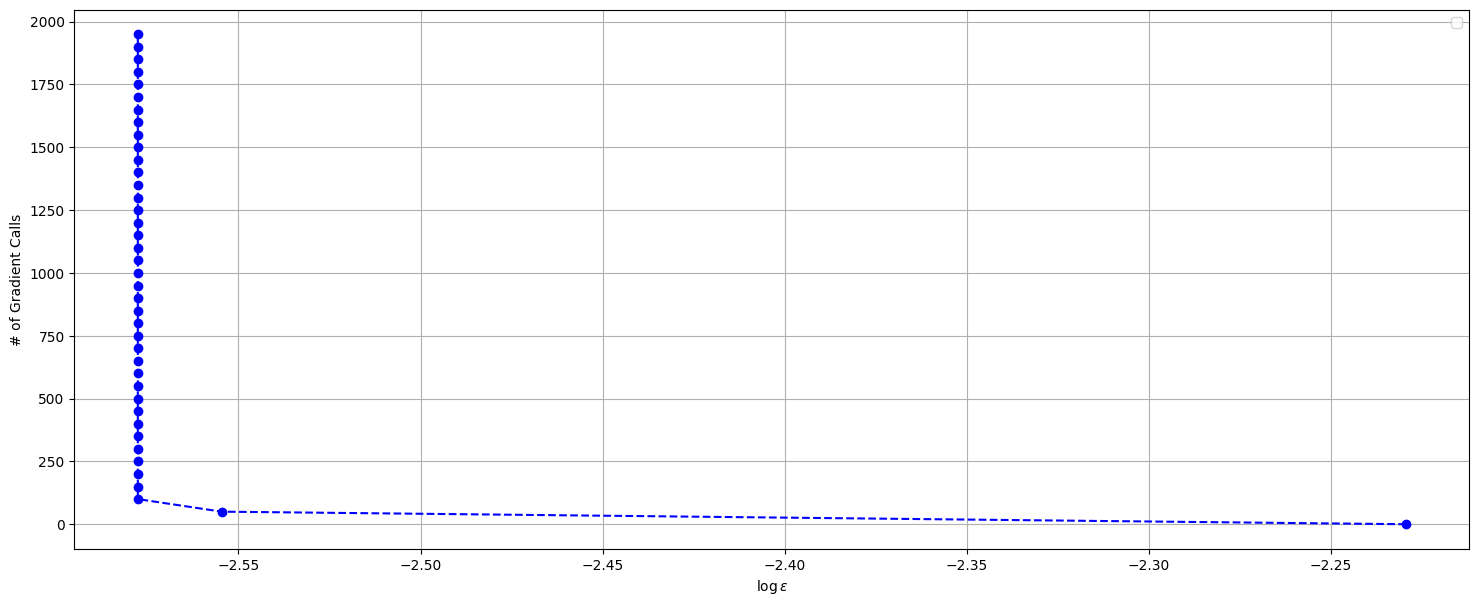

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(SGD_error_list)), epochs, '--bo')
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

Naive Grid Search:

In [ ]:
lam_max = torch.tensor(1)
lam_min = torch.tensor(0)
alpha = torch.tensor(0.5**4)
max_epochs = torch.tensor(5000)
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** torch.arange(2, 12)
print(delta_list)

tensor([0.2500, 0.1250, 0.0625, 0.0312, 0.0156, 0.0078, 0.0039, 0.0020, 0.0010,
        0.0005])


In [ ]:
total_itr_list = []
sup_error_list = []
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = torch.round(1 / torch.sqrt(delta))
    delta_lam = (lam_max - lam_min)/num_grid
    # create a list of lambda's
    lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam).to(device)

    model_list = []
    total_itr = 0

    # first weight is initialized with standard normal distribution
    # weight = torch.normal(0, 1, (1, input_dim))
    weight = torch.zeros(input_dim)

    for lam in lambdas:
        # build the model
        model = Logistic_Regression(input_dim, 1, lam, weight).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
        optimizer.zero_grad()

        # exact solution
        i = torch.round((1-lam) / (0.5**10)).int()
        if i >= len(exact_soln_list):
            i -= 1
            i.int()
        exact_soln = exact_soln_list[i]
        early_stop = False

        for t in range(max_epochs):
            # shrink learning rate
            lr = torch.min(torch.tensor([0.1, alpha/(t+1)]))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            train(SGD_data_loader, model, criterion, optimizer, trace_frequency=5)

            if (t+1) % 10 == 0:
                # do an accuracy check
                approx_soln = test(test_data_loader, model, criterion, lam)
                error = approx_soln - exact_soln
                if error <= delta:
                    total_itr += t+1
                    early_stop = True
                    break  # Early stop

        if not early_stop:
            total_itr += max_epochs

        weight = model.linear.weight
        model_list.append(model)

    total_itr_list.append(total_itr)

    # check sup error
    sup_error = 0
    for i in range(len(exact_soln_list)):
        exact_soln = exact_soln_list[i]
        coarse_grid = torch.round(i * (0.5**10) / delta_lam).int()
        if coarse_grid >= len(model_list):
            coarse_grid -= 1
            coarse_grid.int()
        # print(i, coarse_grid)
        temp = 1 - i * (0.5**10)
        # approximate solution uses the linear weight of coarse grid model to test for regression parameter of the fine grid
        approx_soln = test(test_data_loader, model_list[coarse_grid], criterion, temp)
        sup_error = torch.max(torch.tensor([sup_error, approx_soln - exact_soln]))
        # print(sup_error)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}")
    sup_error_list.append(sup_error.item())

print(f"total_itr_list = {total_itr_list}")
print(f"sup_error_list = {sup_error_list}")

grid #: 2.0	 total iteration #: 20	 sup error: 0.28640124201774597
grid #: 3.0	 total iteration #: 30	 sup error: 0.21828234195709229
grid #: 4.0	 total iteration #: 40	 sup error: 0.18196582794189453
grid #: 6.0	 total iteration #: 60	 sup error: 0.1437608152627945
grid #: 8.0	 total iteration #: 80	 sup error: 0.12091781198978424
grid #: 11.0	 total iteration #: 110	 sup error: 0.10048922896385193
grid #: 16.0	 total iteration #: 160	 sup error: 0.07992546260356903
grid #: 23.0	 total iteration #: 230	 sup error: 0.06336784362792969
grid #: 32.0	 total iteration #: 340	 sup error: 0.05103223770856857
grid #: 45.0	 total iteration #: 780	 sup error: 0.04056680202484131
grid #: 64.0	 total iteration #: 5950	 sup error: 0.030962727963924408
grid #: 91.0	 total iteration #: 29050	 sup error: 0.021841950714588165
total_itr_list = [20, 30, 40, 60, 80, 110, 160, 230, 340, 780, 5950, tensor(29050)]
sup_error_list = [0.28640124201774597, 0.21828234195709229, 0.18196582794189453, 0.14376081526

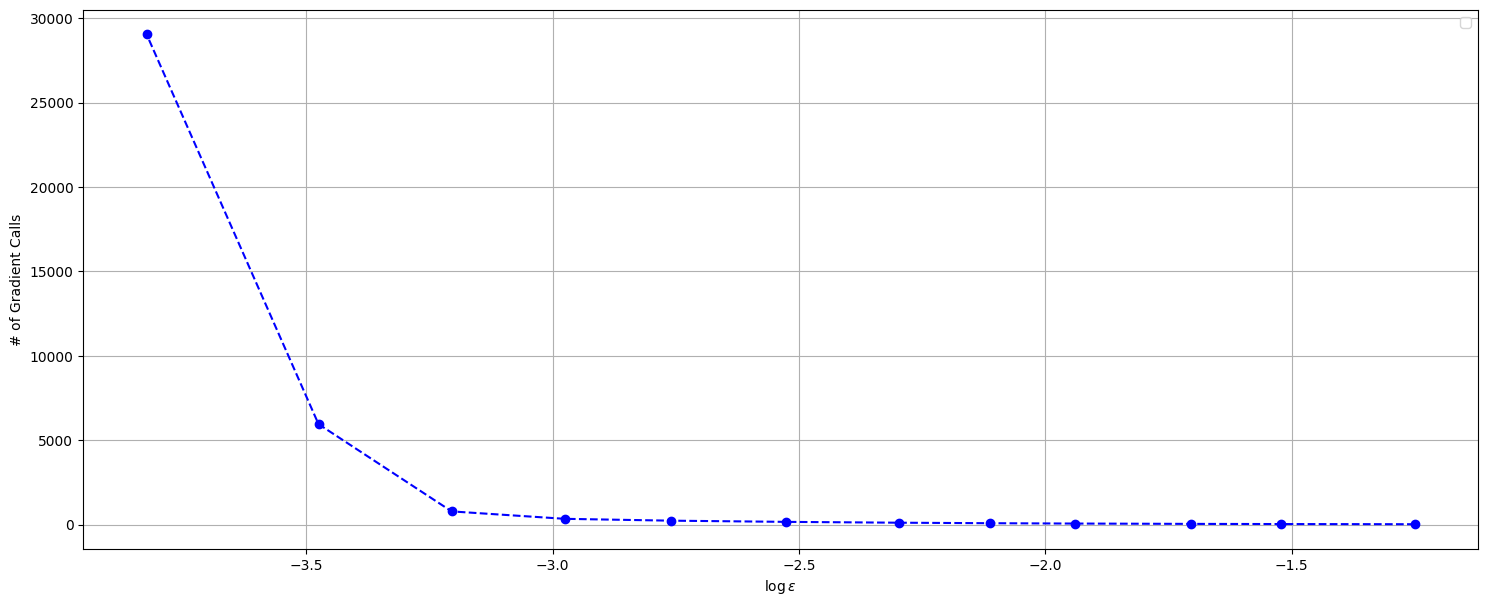

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(sup_error_list)), total_itr_list, '--bo', )
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

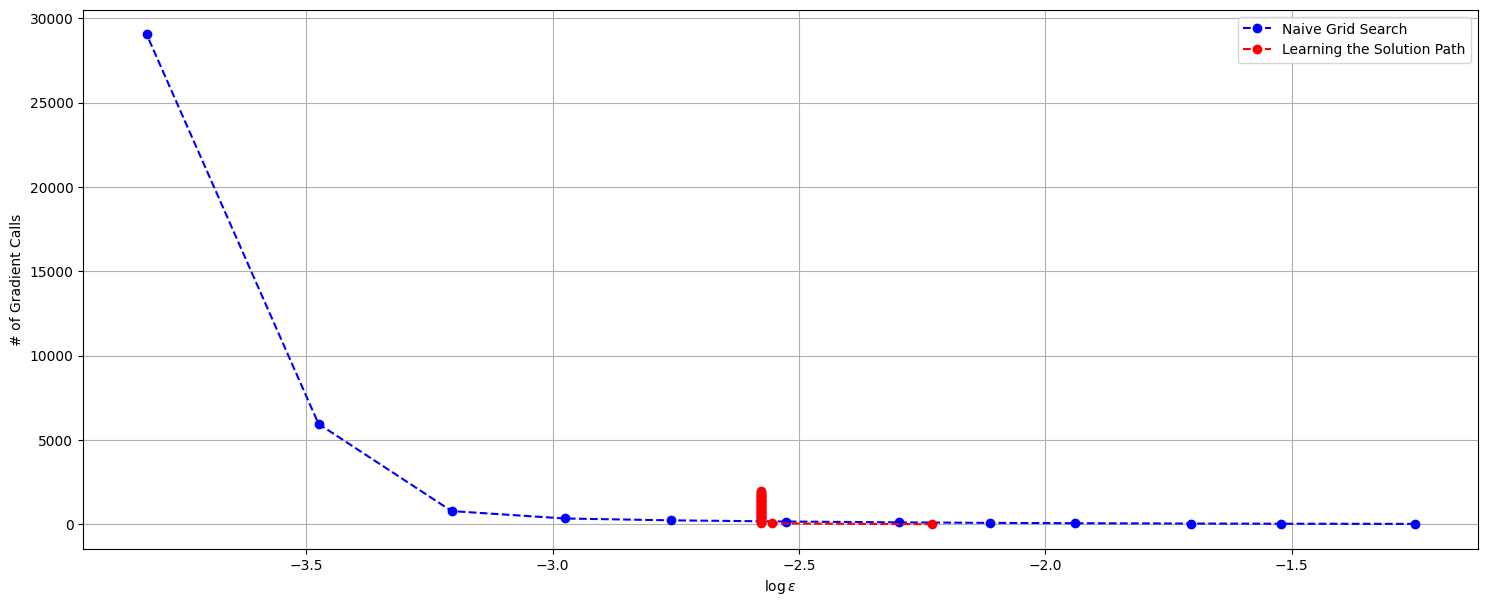

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(sup_error_list)), total_itr_list, '--bo', label = "Naive Grid Search")
plt.plot(torch.log(torch.tensor(SGD_error_list)), epochs, '--ro', label = "Learning the Solution Path")
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

# Mini-experiments

In [ ]:
lam_max = torch.tensor(1)
lam_min = torch.tensor(0)
lr = torch.tensor(0.5**7)
max_epochs = torch.tensor(10000)
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** torch.arange(2, 10)
print(delta_list)

tensor([0.2500, 0.1250, 0.0625, 0.0312, 0.0156, 0.0078, 0.0039, 0.0020])


In [ ]:
# number of grids according to 1/sqrt(delta)
delta = torch.tensor(0.5**10)
num_grid = torch.round(1 / torch.sqrt(delta))
delta_lam = (lam_max - lam_min)/num_grid
# create a list of lambda's
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam).to(device)

model_list = []
total_itr = 0

# first weight is initialized with standard normal distribution
weight = torch.zeros(input_dim)

for lam in lambdas:
    # build the model
    model = Logistic_Regression(input_dim, 1, lam, weight).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    # exact solution
    i = torch.round((1-lam) / (0.5**10)).int()
    if i >= len(exact_soln_list):
        i -= 1
        i.int()
    exact_soln = exact_soln_list[i]
    early_stop = False
    itr = 0
    for t in range(5000):
        train(GD_data_loader, model, criterion, optimizer)

        if (t+1) % 10 == 0:
            # do an accuracy check
            approx_soln = test(test_data_loader, model, criterion, lam)
            error = approx_soln - exact_soln
            if error <=  delta:
                itr = t+1
                early_stop = True
                break  # Early stop

    if not early_stop:
        itr = 5000

    total_itr += itr
    print(f"lambda = {lam}\t train error = {error}\t early stop = {early_stop}\t itr = {itr}")

    weight = model.linear.weight
    model_list.append(model)

# check sup error
sup_error = 0
for i in range(len(exact_soln_list)):
    exact_soln = exact_soln_list[i]
    coarse_grid = torch.round(i * (0.5**10) / delta_lam).int()
    if coarse_grid >= len(model_list):
        coarse_grid -= 1
        coarse_grid.int()
    # print(i, coarse_grid)
    temp = 1 - i * (0.5**10)
    # approximate solution uses the linear weight of coarse grid model to test for regression parameter of the fine grid
    approx_soln = test(test_data_loader, model_list[coarse_grid], criterion, temp)
    sup_error = torch.max(torch.tensor([sup_error, approx_soln - exact_soln]))

    # print(f"lam: {temp} \t exact: {i, exact_soln}\t approx: {coarse_grid.item(), approx_soln}\t sup error:{sup_error}")
print(f"sup error = {sup_error}\t total itr = {total_itr}\t avg itr = {total_itr/num_grid}")
# print(f"total early stop = {total_itr}")

lambda = 1.0	 train error = 0.0	 early stop = True	 itr = 10
lambda = 0.96875	 train error = 0.0009753182530403137	 early stop = True	 itr = 2830
lambda = 0.9375	 train error = 0.0009482316672801971	 early stop = True	 itr = 50
lambda = 0.90625	 train error = 0.0009024441242218018	 early stop = True	 itr = 40
lambda = 0.875	 train error = 0.0009722486138343811	 early stop = True	 itr = 1760
lambda = 0.84375	 train error = 0.000975385308265686	 early stop = True	 itr = 2200
lambda = 0.8125	 train error = 0.0009761303663253784	 early stop = True	 itr = 2500
lambda = 0.78125	 train error = 0.0009687095880508423	 early stop = True	 itr = 2390
lambda = 0.75	 train error = 0.0009750127792358398	 early stop = True	 itr = 1950
lambda = 0.71875	 train error = 0.0009727627038955688	 early stop = True	 itr = 2480
lambda = 0.6875	 train error = 0.0009695589542388916	 early stop = True	 itr = 1580
lambda = 0.65625	 train error = 0.0009696483612060547	 early stop = True	 itr = 1930
lambda = 0.625	 t

New experiment to test validity of exact solution path

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

Before setting seed on initilization of the NN model, same code yields different iteration results.

In [ ]:
i = 62
# 0.93896484375
lam = 1 - i * (0.5**10)
print(lam)
init_weight = exact_model_list[i-1].linear.weight
print(init_weight)
# build the model
model = Logistic_Regression(input_dim, 1, lam, init_weight).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for t in range(5000):
        train(GD_data_loader, model, criterion, optimizer, trace_frequency=5)

approx_soln = test(GD_data_loader, model, criterion, lam)
print(f"old optimal soln = {approx_soln}")
print(model.linear.weight)

0.939453125
Parameter containing:
tensor([[-0.0102, -0.0059, -0.0104, -0.0099, -0.0049, -0.0082, -0.0096, -0.0108,
         -0.0045,  0.0004, -0.0078,  0.0002, -0.0076, -0.0075,  0.0010, -0.0039,
         -0.0033, -0.0056,  0.0002, -0.0009, -0.0109, -0.0065, -0.0109, -0.0102,
         -0.0059, -0.0082, -0.0092, -0.0111, -0.0059, -0.0045]],
       requires_grad=True)
old optimal soln = 0.03867004066705704
Parameter containing:
tensor([[-0.0104, -0.0060, -0.0105, -0.0100, -0.0050, -0.0083, -0.0098, -0.0110,
         -0.0046,  0.0004, -0.0080,  0.0002, -0.0078, -0.0077,  0.0010, -0.0039,
         -0.0034, -0.0056,  0.0002, -0.0009, -0.0111, -0.0066, -0.0111, -0.0104,
         -0.0060, -0.0083, -0.0093, -0.0113, -0.0060, -0.0045]],
       requires_grad=True)


In [ ]:
i = 62
# 0.93896484375
lam = 1 - i * (0.5**10)
print(lam)
init_weight = exact_model_list[i-1].linear.weight
print(init_weight)
# build the model
model = Logistic_Regression(input_dim, 1, lam, init_weight).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for t in range(5000):
        train(GD_data_loader, model, criterion, optimizer, trace_frequency=5)

approx_soln = test(GD_data_loader, model, criterion, lam)
print(f"old optimal soln = {approx_soln}")
print(model.linear.weight)

0.939453125
Parameter containing:
tensor([[-0.0102, -0.0059, -0.0104, -0.0099, -0.0049, -0.0082, -0.0096, -0.0108,
         -0.0045,  0.0004, -0.0078,  0.0002, -0.0076, -0.0075,  0.0010, -0.0039,
         -0.0033, -0.0056,  0.0002, -0.0009, -0.0109, -0.0065, -0.0109, -0.0102,
         -0.0059, -0.0082, -0.0092, -0.0111, -0.0059, -0.0045]],
       requires_grad=True)
old optimal soln = 0.03867019712924957
Parameter containing:
tensor([[-0.0104, -0.0060, -0.0105, -0.0100, -0.0050, -0.0083, -0.0098, -0.0110,
         -0.0046,  0.0004, -0.0080,  0.0002, -0.0078, -0.0077,  0.0010, -0.0039,
         -0.0034, -0.0056,  0.0002, -0.0009, -0.0111, -0.0066, -0.0111, -0.0104,
         -0.0060, -0.0083, -0.0093, -0.0113, -0.0060, -0.0045]],
       requires_grad=True)


In [ ]:
print(torch.tensor([-0.0104, -0.0060, -0.0105, -0.0100, -0.0050, -0.0083, -0.0098, -0.0110,
         -0.0046,  0.0004, -0.0080,  0.0002, -0.0078, -0.0077,  0.0010, -0.0039,
         -0.0034, -0.0056,  0.0002, -0.0009, -0.0111, -0.0066, -0.0111, -0.0104,
         -0.0060, -0.0083, -0.0093, -0.0113, -0.0060, -0.0045]) - torch.tensor([-0.0104, -0.0060, -0.0105, -0.0100, -0.0050, -0.0083, -0.0098, -0.0110,
         -0.0046,  0.0004, -0.0080,  0.0002, -0.0078, -0.0077,  0.0010, -0.0039,
         -0.0034, -0.0056,  0.0002, -0.0009, -0.0111, -0.0066, -0.0111, -0.0104,
         -0.0060, -0.0083, -0.0093, -0.0113, -0.0060, -0.0045]))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


After setting seed on initialization, the iteration results become fixed.

In [ ]:
SEED = 2021
set_seed(seed=SEED)
init_weight = torch.zeros(input_dim)
lam = 0
# print(init_weight)
# build the model
model = Logistic_Regression(input_dim, 1, lam, init_weight).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer.zero_grad

Random seed 2021 has been set.


<bound method Optimizer.zero_grad of SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)>

In [ ]:
for t in range(500):
        train(GD_data_loader, model, criterion, optimizer, trace_frequency=5)

approx_soln = test(test_data_loader, model, criterion, lam)
print(f"old optimal soln = {approx_soln}")
print(model.linear.weight)

old optimal soln = 0.3263639509677887
Parameter containing:
tensor([[-0.1035, -0.0639, -0.1045, -0.0993, -0.0461, -0.0739, -0.0909, -0.1064,
         -0.0413,  0.0135, -0.0764,  0.0031, -0.0730, -0.0728,  0.0124, -0.0263,
         -0.0210, -0.0468,  0.0066,  0.0036, -0.1114, -0.0723, -0.1111, -0.1036,
         -0.0620, -0.0782, -0.0885, -0.1111, -0.0615, -0.0407]],
       requires_grad=True)


In [ ]:
SEED = 2021
set_seed(seed=SEED)
init_weight = torch.zeros(input_dim)
lam = 0
# print(init_weight)
# build the model
model = Logistic_Regression(input_dim, 1, lam, init_weight).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer.zero_grad

Random seed 2021 has been set.


<bound method Optimizer.zero_grad of SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)>

In [ ]:
for t in range(500):
        train(GD_data_loader, model, criterion, optimizer, trace_frequency=5)

approx_soln = test(test_data_loader, model, criterion, lam)
print(f"old optimal soln = {approx_soln}")
print(model.linear.weight)

old optimal soln = 0.3263639509677887
Parameter containing:
tensor([[-0.1035, -0.0639, -0.1045, -0.0993, -0.0461, -0.0739, -0.0909, -0.1064,
         -0.0413,  0.0135, -0.0764,  0.0031, -0.0730, -0.0728,  0.0124, -0.0263,
         -0.0210, -0.0468,  0.0066,  0.0036, -0.1114, -0.0723, -0.1111, -0.1036,
         -0.0620, -0.0782, -0.0885, -0.1111, -0.0615, -0.0407]],
       requires_grad=True)


#Discarded

Since we are doing optimization, there is no need to do a train-test split. Instead, we will train and test on the whole dataset.

In [ ]:
# # Split dataset
# # test : val : train = 2 : 1 : 7
# # Not using validation set for now
# from torch.utils.data import random_split

# test_size = torch.tensor(len(reg_data) * 0.3).int()
# #val_size = torch.tensor(len(reg_data) * 0.1).int()
# train_size = len(reg_data) - test_size
# train_set, test_set = random_split(reg_data, [train_size, test_size])

# train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, )
# test_data_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False, )

# # print(next(iter(test_data_loader)))

In [ ]:
lr_list = 0.5 ** torch.arange(2, 13)
num_epochs = torch.tensor([100, 500, 1000])
print(lr_list)
print(num_epochs)
max_epoch = torch.max(num_epochs)

tensor([2.5000e-01, 1.2500e-01, 6.2500e-02, 3.1250e-02, 1.5625e-02, 7.8125e-03,
        3.9062e-03, 1.9531e-03, 9.7656e-04, 4.8828e-04, 2.4414e-04])
tensor([ 100,  500, 1000])


In [ ]:
# tune learning rate on the first 100 datapoints
data = Regression_Data(X[:100, :], y[:100])
# full gradient descent uses all data points
GD_data_loader = DataLoader(data, batch_size=len(data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(data, batch_size=5, shuffle=True, )
# test data
test_data_loader = DataLoader(data, batch_size=len(reg_data), shuffle=False, )

##Selecting the Best Number of Grid Points to Use for Tuning the Learning Rate
We take
\begin{align*}
\sup_{\lambda} \{h(\hat{\theta}(\lambda), \lambda) - h(\theta^*(\lambda), \lambda)\}
\end{align*}
over a list of uniformly spaced $\lambda$'s. To simulate $\theta^*(\lambda)$, we onstruct a very fine grid of $\lambda$ and run SGD over this grid.

In [ ]:
tune_data = Regression_Data(X[:100, :], y[:100])
tune_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )

In [ ]:
lam_max = torch.tensor(1).to(device)
lam_min = torch.tensor(0).to(device)
fine_num_grid = 2**10
epochs = 5000
fine_delta_lam = (lam_max - lam_min)/fine_num_grid

In [ ]:
# a fine grid to simulate the exact solution path $\theta^*(\lambda)$
tune_fine_model_list = naive_grid_search(lam_min, lam_max, num_grid, epochs, tune_data_loader, 1e-3)
tune_exact_soln_list = []
for model in tune_fine_model_list:
    tune_exact_soln_list.append(test(tune_data_loader, model, criterion, model.reg_param))
print("---------tune exact solution path complete----------")
print(f"tune_exact_soln_list = {tune_exact_soln_list}")

---------tune exact solution path complete----------
tune_exact_soln_list = [5.022323179559862e-08, 0.03418022394180298, 0.06836150586605072, 0.1904347985982895, 0.13672712445259094, 0.17091143131256104, 0.205097958445549, 0.4443650245666504, 0.5078492760658264, 0.3076607882976532, 0.6348252296447754, 0.3760388493537903, 0.750082790851593, 0.4444253742694855, 0.47861701250076294, 0.9522795081138611, 0.547005832195282, 0.14956888556480408, 0.6153932213783264, 0.6125032901763916, 0.6837976574897766, 0.20531418919563293, 0.19361737370491028, 0.24734807014465332, 0.28155624866485596, 0.3665352165699005, 1.2445142269134521, 0.6595515012741089, 0.13712765276432037, 0.19867625832557678, 1.1723679304122925, 1.120642066001892, 1.2818101644515991, 0.2261485755443573, 1.1626673936843872, 0.9576839208602905, 0.6334936022758484, 0.651107668876648, 1.2995201349258423, 1.33372962474823, 0.35236018896102905, 0.5213660597801208, 1.0262432098388672, 0.37884265184402466, 0.30175331234931946, 0.2207299023

In [ ]:
# number of grid points in the coarse grids, created as subsets of the fine grid
num_grid_list = 2 ** torch.arange(2, 10)
print(f"num_grid_list = {num_grid_list}")

num_grid_list = tensor([  4,   8,  16,  32,  64, 128, 256, 512])


In [ ]:
error_list = []

for num in torch.arange(2, 10):
    sup_error = 0
    skip = 2 ** (10 - num)

    for i in range(len(tune_exact_soln_list)):
        exact_soln = tune_exact_soln_list[i]
        temp = 1 - i * fine_delta_lam

        coarse_grid = (torch.round(i/ skip) * skip).int()
        if coarse_grid >= len(tune_exact_soln_list):
            coarse_grid -= skip
            coarse_grid.int()
        # print(i, coarse_grid)

        # approximate solution uses the linear weight of coarse grid model to test for regression parameter of the fine grid
        approx_soln = test(tune_data_loader, tune_fine_model_list[coarse_grid], criterion, temp)
        sup_error = torch.max(torch.tensor([sup_error, approx_soln - exact_soln]))
        # print(sup_error)

    print(f"# grid: {2**num}\t sup error: {sup_error}")
    error_list.append(sup_error)

print(f"error_list = {error_list}")

# grid: 4	 sup error: 10.799158096313477
# grid: 8	 sup error: 6.149971008300781
# grid: 16	 sup error: 4.406752109527588
# grid: 32	 sup error: 3.3502249717712402
# grid: 64	 sup error: 3.4311978816986084
# grid: 128	 sup error: 3.417623519897461
# grid: 256	 sup error: 3.481377363204956
# grid: 512	 sup error: 3.481377363204956
error_list = [tensor(10.7992), tensor(6.1500), tensor(4.4068), tensor(3.3502), tensor(3.4312), tensor(3.4176), tensor(3.4814), tensor(3.4814)]


In [ ]:
tune_error_list = []
num_grid_list = []
for num in torch.arange(2, 10):
    # number of grid points in the coarse grid
    num_grid = 2**num
    num_grid_list.append(num_grid)
    delta_lam = (lam_max - lam_min)/num_grid

    # build the coarse grid by selecting from the fine grid
    skip = (fine_num_grid/num_grid).int()
    coarse_model_list = tune_fine_model_list[0::skip]

    sup_error = get_sup_error(tune_exact_soln_list, fine_delta_lam, coarse_model_list, delta_lam, tune_data_loader, criterion)
    print(f"# grid: {num_grid}\t sup error: {sup_error}")
    error_list.append(sup_error)

print(f"tune_error_list = {tune_error_list}")

Selecting the Number of Grids for Naive Grid Search:
Plot $\sup_{\lambda} \{h(\hat{\theta}(\lambda), \lambda) - h(\theta^*(\lambda), \lambda)\}$ against $\Delta\lambda$. A grid number of $2^5 = 32$

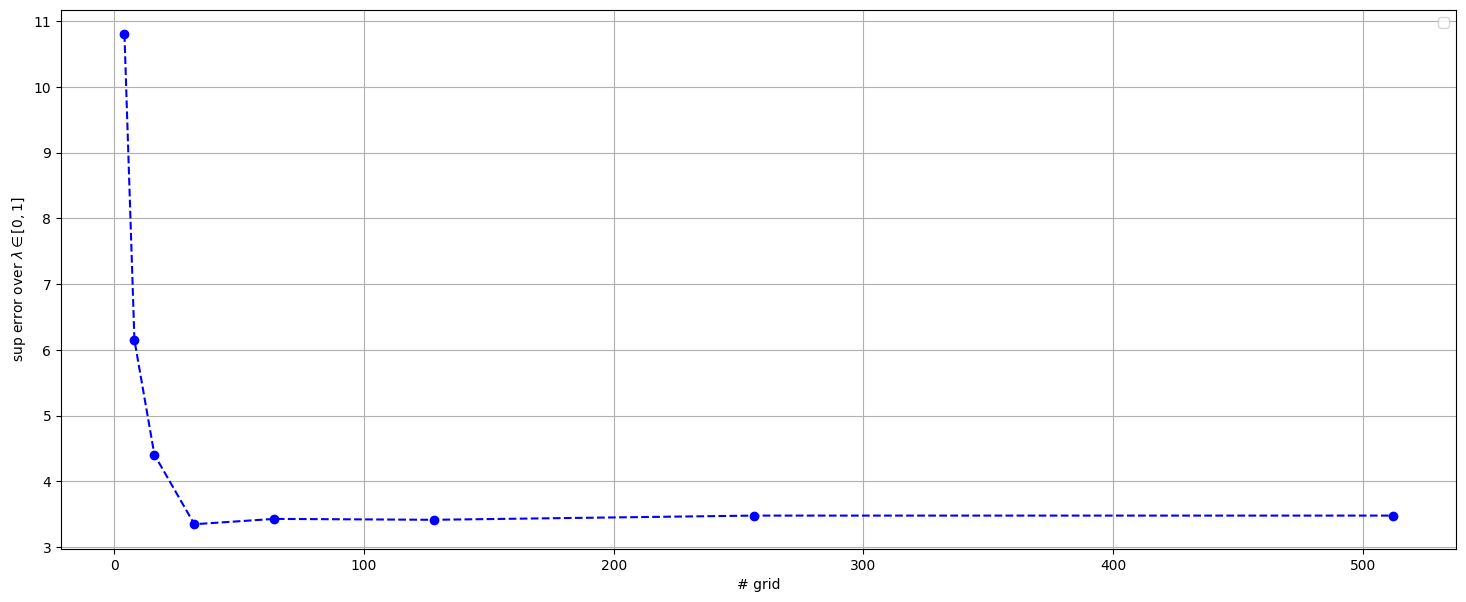

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(num_grid_list, error_list, '--bo')
plt.xlabel('# grid')
plt.ylabel(f"sup error over $\\lambda\\in [{lam_min}, {lam_max}]$")
plt.legend()
plt.grid(True)

## Tuning the Learning Rate

Use the first 100 datapoints to select the best constant learning rate for learning the solution path when # basis = 3.

Make several plots of sup error along the solution path against learning rate using 1000 epochs.

In [ ]:
errs = []
for lr in lr_list:
    # train a model
    model = Logistic_Regression(data.input_dim, 1, 0.01, torch.zeros(data.input_dim))
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()
    temp = []
    for t in range(max_epoch):
        train(GD_data_loader, model, criterion, optimizer, trace_frequency=5)
        for epoch in num_epochs:
            if t == epoch - 1:
                loss = test(GD_data_loader, model, criterion, model.reg_param)
                temp.append(loss)
    errs.append(temp)

errs = np.array(errs).T
print(errs)

[[ 2.01097894  2.99287939  2.98511267  3.9691689   4.9551034   4.95267773
   6.93122005  9.90048504  7.92014647 12.87004757 26.73001099]
 [ 2.01851606  2.01717019  2.01284623  2.0054462   2.98734736  3.97083163
   3.96624422  4.95335102  4.95150757  8.91065311  5.94021463]
 [ 2.01875758  2.01852465  2.01716113  2.01288867  2.00538826  2.98739743
   3.97081733  3.96626663  4.95322227  5.94158411  4.95061636]]


<ipython-input-62-e031e0da55e3>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(torch.log(lr_list), errs[i], '--bo', color = colors[i], label = f"# Epochs = {num_epochs[i].item()}")


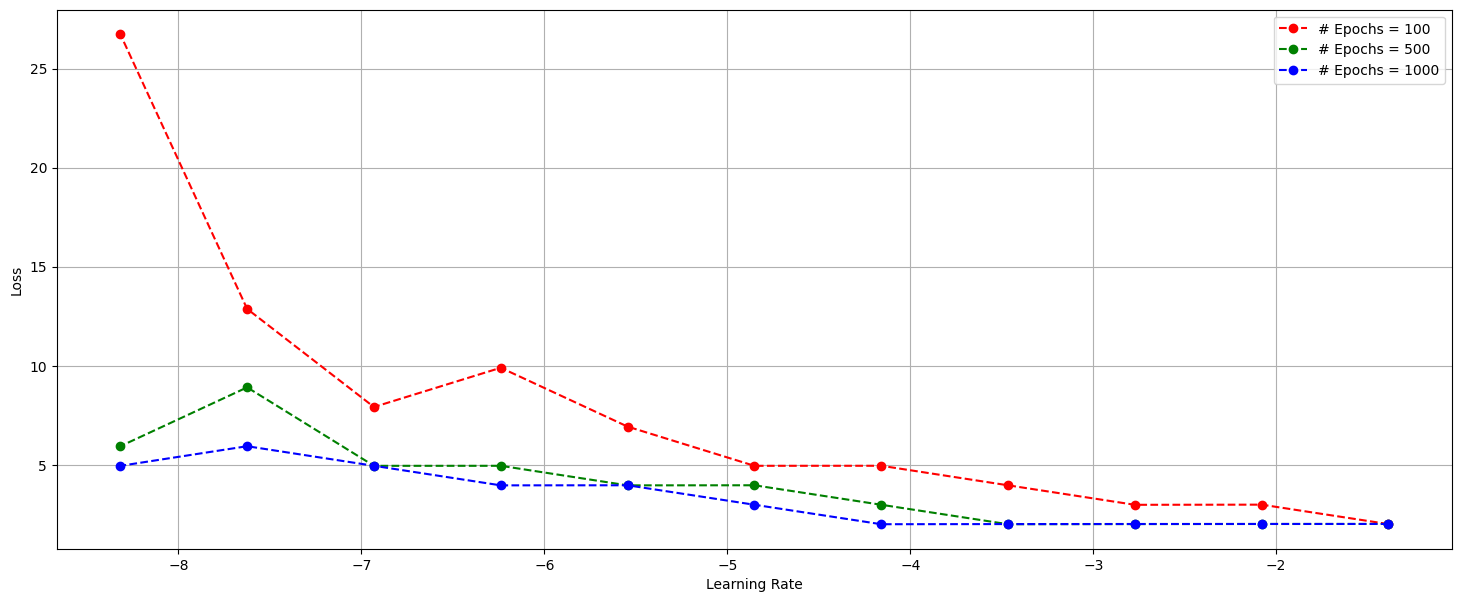

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
colors = ['r', 'g', 'b']
for i in range(len(num_epochs)):
    plt.plot(torch.log(lr_list), errs[i], '--bo', color = colors[i], label = f"# Epochs = {num_epochs[i].item()}")
plt.xlabel('Learning Rate')
plt.ylabel(f"Loss")
plt.legend()
plt.grid(True)

In [ ]:
# Compute the approximate solution path
def solution_path_SGD(basis_dim, epochs):
    # build the model
    weight = torch.normal(0, 1, (1, reg_data.input_dim*basis_dim))
    model = Logistic_Regression(reg_data.input_dim*basis_dim, 1, 0, weight).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    optimizer.zero_grad()

    for t in range(epochs):
        train_SGD(GD_data_loader, model, criterion, optimizer, basis_dim, trace_frequency=5)

    #print(model.norm_beta())
    print("Done!")

    return model

In [ ]:
basis_dim = torch.tensor(3).to(device)
max_epoch = torch.tensor(100).to(device)
model_SGD = solution_path_SGD(basis_dim, max_epoch)
print(f"---------approximate solution path for basis dimension = {basis_dim} complete----------")
weight = torch.clone(model_SGD.linear.weight).detach()

Done!
---------approximate solution path for basis dimension = 3 complete----------


In [ ]:
print(failed)
print(lams)
print(errs)

[0.9750000238418579, 0.9624999761581421, 0.887499988079071, 0.824999988079071, 0.7875000238418579, 0.037499986588954926, 0.012499985285103321]
[1.0, 0.9990234375, 0.998046875, 0.9970703125, 0.99609375, 0.9951171875, 0.994140625, 0.9931640625, 0.9921875, 0.9912109375, 0.990234375, 0.9892578125, 0.98828125, 0.9873046875, 0.986328125, 0.9853515625, 0.984375, 0.9833984375, 0.982421875, 0.9814453125, 0.98046875, 0.9794921875, 0.978515625, 0.9775390625, 0.9765625, 0.9755859375, 0.974609375, 0.9736328125, 0.97265625, 0.9716796875, 0.970703125, 0.9697265625, 0.96875, 0.9677734375, 0.966796875, 0.9658203125, 0.96484375, 0.9638671875, 0.962890625, 0.9619140625, 0.9609375, 0.9599609375, 0.958984375, 0.9580078125, 0.95703125, 0.9560546875, 0.955078125, 0.9541015625, 0.953125, 0.9521484375, 0.951171875, 0.9501953125, 0.94921875, 0.9482421875, 0.947265625, 0.9462890625, 0.9453125, 0.9443359375, 0.943359375, 0.9423828125, 0.94140625, 0.9404296875, 0.939453125, 0.9384765625, 0.9375, 0.9365234375, 0.93

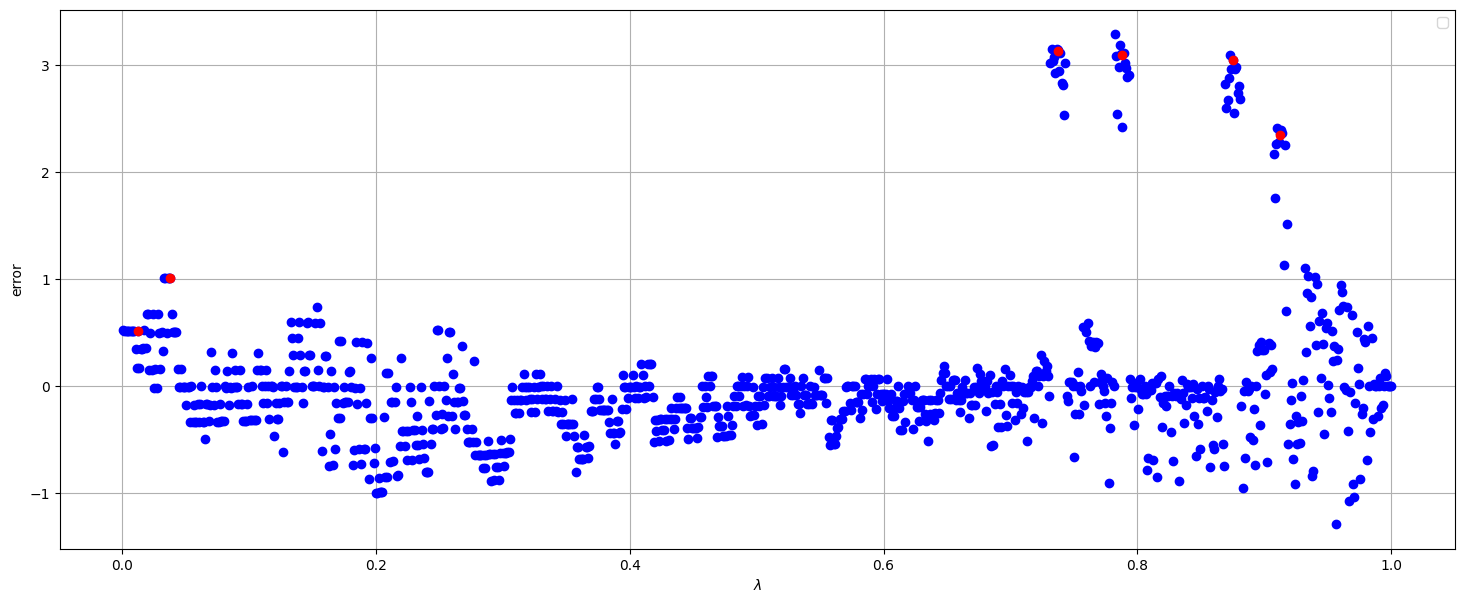

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(lams, errs, 'bo')
plt.plot(failed, train_errs, 'ro')
plt.ylabel('error')
plt.xlabel('$\\lambda$')
plt.legend()
plt.grid(True)

### Archival (Ignorable for now)

@Qiran: You might find the code below useful for saving the best solution so far in SGD (SGD performance is non-monotonic).  I think (let's confirm with Paul) this is preferred to actually averaging iterates.

In [ ]:
import copy

In [ ]:
n_epochs = 100   # number of epochs to run.  Each epoch is a full pass of data
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()